In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import scipy.stats as ss
from scipy.optimize import curve_fit
from scipy.stats import norm
from ntuple_lib import *
beautify_plots(plt)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib as mpl
plt.rcParams["figure.figsize"] = (12, 8)

c:\Users\thoma\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
def computeLocalPUDensity(all_events_vertex_xs, delta_x):
    localPUdensity = []
    for vertex_xs in all_events_vertex_xs:
        localPUdensity.append((np.sum(np.abs(vertex_xs[0]-vertex_xs[1:]) < delta_x))/(2*delta_x))
    return localPUdensity
def computeAvgPUDensity(all_events_vertex_xs, mu=200, sigma_x=50):
    avgPUdensity = []
    for vertex_xs in all_events_vertex_xs:
        avgPUdensity.append(mu/(sigma_x*np.sqrt(2*np.pi)) * np.exp(-0.5*vertex_xs[0]**2/sigma_x**2))
    return avgPUdensity
def abs_event_to_specific_ntuple_event(abs_event, files):
    n_events_loaded = 0
    for file in files:
        root_file = uproot.open(file)
        for key in root_file.keys():
            if key.startswith('EventTree'):
                tree = root_file[key]
                n_events_in_tree = len(tree['track_t'].array(library='np'))
                if n_events_loaded+n_events_in_tree > abs_event:
                    return file, key, abs_event-n_events_loaded
                n_events_loaded += n_events_in_tree

In [148]:
# files = ['ntuples_condor/OutDir_{}/hist-Rel21sample.root'.format(i) for i in range(1, 10)]
files = ['../ntuples/ttbar/OutDir_{}/hist-Rel21sample.root'.format(i) for i in range(3, 31)]
track_z0 = np.array([], dtype='object') 
track_z0_var = np.array([], dtype='object') 
track_t = np.array([], dtype='object')
track_t30 = np.array([], dtype='object')
track_t90 = np.array([], dtype='object')
track_t180 = np.array([], dtype='object')

reco_vertex_track_idxs = np.array([], dtype='object')
reco_vertex_track_weights = np.array([], dtype='object')
truth_vertex_track_idxs = np.array([], dtype='object')

# reco_vertex_sumPt2 = np.array([], dtype='object')

reco_vertex_z = np.array([], dtype='object')
truth_vertex_z = np.array([], dtype='object')
truth_vertex_t = np.array([], dtype='object')
track_qOverP = np.array([], dtype='object') 
track_theta = np.array([], dtype='object')
for file in files:
    root_file = uproot.open(file)
    for key in root_file.keys():
        if key.startswith('EventTree'):
            tree = root_file[key]
            track_z0 = np.concatenate((track_z0, tree['track_z0'].array(library='np')))
            track_z0_var = np.concatenate((track_z0_var, tree['track_var_z0'].array(library='np')))
            track_t = np.concatenate((track_t, tree['track_t'].array(library='np')))
            track_t30 = np.concatenate((track_t30, tree['track_t30'].array(library='np')))
            track_t90 = np.concatenate((track_t90, tree['track_t90'].array(library='np')))
            track_t180 = np.concatenate((track_t180, tree['track_t180'].array(library='np')))
            
            reco_vertex_track_idxs = np.concatenate((reco_vertex_track_idxs, tree['recovertex_tracks_idx'].array(library='np')))
            reco_vertex_track_weights = np.concatenate((reco_vertex_track_weights, tree['recovertex_tracks_weight'].array(library='np')))
            truth_vertex_track_idxs = np.concatenate((truth_vertex_track_idxs, tree['truthvertex_tracks_idx'].array(library='np')))
            
            # reco_vertex_sumPt2 = np.concatenate((reco_vertex_sumPt2, tree['recovertex_sumPt2'].array(library='np')))
            
            reco_vertex_z = np.concatenate((reco_vertex_z, tree['recovertex_z'].array(library='np')))
            truth_vertex_z = np.concatenate((truth_vertex_z, tree['truthvertex_z'].array(library='np')))
            truth_vertex_t = np.concatenate((truth_vertex_t, tree['truthvertex_t'].array(library='np')))
            
            track_qOverP = np.concatenate((track_qOverP, tree['track_qOverP'].array(library='np')))
            track_theta = np.concatenate((track_theta, tree['track_theta'].array(library='np')))

track_pT = np.abs(np.array([np.sin(theta) for theta in track_theta], dtype='object')/track_qOverP)
print(len(track_t), ' events loaded')

25790  events loaded


In [160]:
reco_vertex_track_weights_flat = np.concatenate(np.concatenate(reco_vertex_track_weights))
reco_vertex_HS_track_weights_flat = np.array([])
reco_vertex_HS_n_tracks_flat = []
for event_idx, event_weights in enumerate(reco_vertex_track_weights):
    reco_vertex_HS_track_weights_flat = np.concatenate((reco_vertex_HS_track_weights_flat, event_weights[truthHS_to_reco_delta_z_cut_link_idx[event_idx]]))
    reco_vertex_HS_n_tracks_flat.append(len(event_weights[truthHS_to_reco_delta_z_cut_link_idx[event_idx]]))

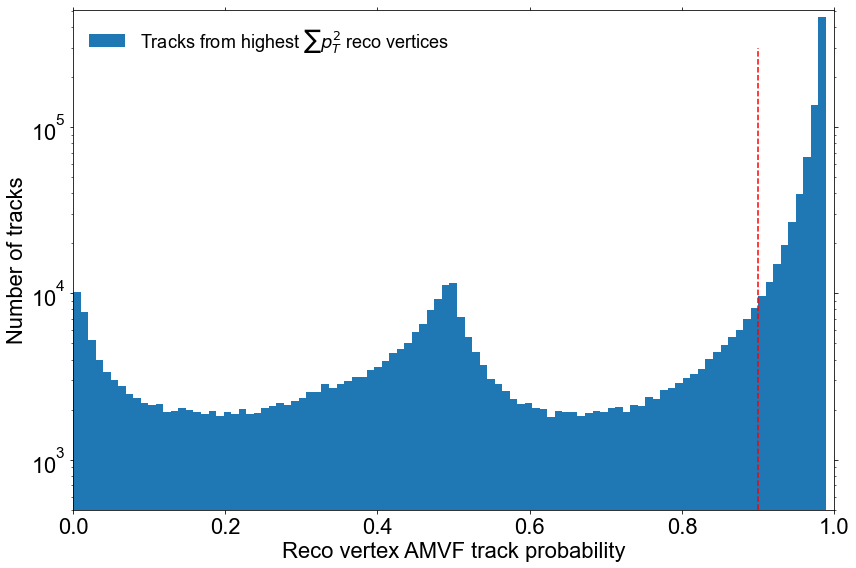

In [338]:
# _ = plt.hist(reco_vertex_track_weights_flat, bins=100, label='All reco vertices')
hist = plt.hist(reco_vertex_HS_track_weights_flat, bins=100, label='Tracks from highest $\sum p_T^2$ reco vertices')
plt.yscale('log')
# plt.vlines(0.5, 0, 1e5, color='g', ls='--')
plt.vlines(0.9, 0, 3e5, color='r', ls='--')
plt.xlim(0, 1)
plt.ylim(5e2, np.max(hist[0])*1.1)
plt.xlabel('Reco vertex AMVF track probability')
plt.ylabel('Number of tracks')
plt.legend(frameon=False)
plt.tight_layout()
# plt.savefig('figs/AMVF_weights_v1.pdf')

In [155]:
## Find truth reco link via number of shared tracks
delta_z_link_cut = 0.5

truthHS_to_reco_link_idx = []
truthHS_to_reco_link_n_shared_tracks = []

truthHS_to_reco_delta_z_cut_link_idx = []
truthHS_to_reco_delta_z_cut_link_n_shared_tracks = []
truthHS_to_reco_delta_z_cut_link_n_shared_tracks_rel_weight = []

truthHS_to_reco_link_idx_req_HS = []
truthHS_to_reco_link_n_shared_tracks_req_HS = []

truthHS_to_reco_link_idx_req_clean = []
truthHS_to_reco_link_n_shared_tracks_req_clean = []

truthHS_to_reco_link_idx_req_cleanHS = []
truthHS_to_reco_link_n_shared_tracks_req_cleanHS = []

for event_idx in range(len(truth_vertex_t)):
    event_truth_to_reco_idx = -1
    event_truth_to_reco_n_tracks = -1

    event_truth_to_reco_delta_z_cut_idx = -1
    event_truth_to_reco_delta_z_cut_n_tracks = -1
    event_truth_to_reco_delta_z_cut_shared_tracks_rel_weight = -1

    event_truth_to_reco_idx_req_clean = -1
    event_truth_to_reco_n_tracks_req_clean = -1

    event_truth_to_reco_idx_req_cleanHS = -1
    event_truth_to_reco_n_tracks_req_cleanHS = -1

    event_truth_to_reco_n_tracks_req_HS = -1
    event_truth_to_reco_idx_req_HS = -1

    truth_hs_track_idx = truth_vertex_track_idxs[event_idx][0]
    for i, reco_track_idxs in enumerate(reco_vertex_track_idxs[event_idx]):
        if i < 100:
            intersecting_tracks, _, reco_shared_tracks_idxs = np.intersect1d(truth_hs_track_idx, reco_track_idxs, return_indices=True)
            n = len(intersecting_tracks)
            # print(n)
            if n > event_truth_to_reco_n_tracks:
                event_reco_total_weight = np.sum(reco_vertex_track_weights[event_idx][i])
                event_reco_shared_Weight = np.sum(reco_vertex_track_weights[event_idx][i][reco_shared_tracks_idxs])

                event_truth_to_reco_idx = i
                event_truth_to_reco_n_tracks = n
                if np.abs(truth_vertex_z[event_idx][0] - reco_vertex_z[event_idx][i]) < delta_z_link_cut:
                    event_truth_to_reco_delta_z_cut_idx = i
                    event_truth_to_reco_delta_z_cut_n_tracks = n
                    event_truth_to_reco_delta_z_cut_shared_tracks_rel_weight = event_reco_shared_Weight/event_reco_total_weight
    
    ## Require reco HS
    if event_truth_to_reco_delta_z_cut_idx == 0:
        event_truth_to_reco_idx_req_HS = 0
        event_truth_to_reco_n_tracks_req_HS = event_truth_to_reco_delta_z_cut_n_tracks
    
    if event_truth_to_reco_delta_z_cut_shared_tracks_rel_weight > 0.7:
        event_truth_to_reco_idx_req_clean = event_truth_to_reco_delta_z_cut_idx
        event_truth_to_reco_n_tracks_req_clean = event_truth_to_reco_delta_z_cut_n_tracks
        if event_truth_to_reco_delta_z_cut_idx == 0:
            event_truth_to_reco_idx_req_cleanHS = 0
            event_truth_to_reco_n_tracks_req_cleanHS = event_truth_to_reco_delta_z_cut_n_tracks


    truthHS_to_reco_link_idx.append(event_truth_to_reco_idx)
    truthHS_to_reco_link_n_shared_tracks.append(event_truth_to_reco_n_tracks)    
    
    truthHS_to_reco_delta_z_cut_link_idx.append(event_truth_to_reco_delta_z_cut_idx)
    truthHS_to_reco_delta_z_cut_link_n_shared_tracks.append(event_truth_to_reco_delta_z_cut_n_tracks)    
    truthHS_to_reco_delta_z_cut_link_n_shared_tracks_rel_weight.append(event_truth_to_reco_delta_z_cut_shared_tracks_rel_weight)    
    
    truthHS_to_reco_link_idx_req_HS.append(event_truth_to_reco_idx_req_HS)
    truthHS_to_reco_link_n_shared_tracks_req_HS.append(event_truth_to_reco_n_tracks_req_HS)

    truthHS_to_reco_link_idx_req_clean.append(event_truth_to_reco_idx_req_clean)
    truthHS_to_reco_link_n_shared_tracks_req_clean.append(event_truth_to_reco_n_tracks_req_clean)

    truthHS_to_reco_link_idx_req_cleanHS.append(event_truth_to_reco_idx_req_cleanHS)
    truthHS_to_reco_link_n_shared_tracks_req_cleanHS.append(event_truth_to_reco_n_tracks_req_cleanHS)

truthHS_to_reco_link_idx = np.array(truthHS_to_reco_link_idx)
truthHS_to_reco_link_idx_req_HS = np.array(truthHS_to_reco_link_idx_req_HS)
truthHS_to_reco_delta_z_cut_link_idx = np.array(truthHS_to_reco_delta_z_cut_link_idx)
truthHS_to_reco_link_idx_req_clean = np.array(truthHS_to_reco_link_idx_req_clean)
truthHS_to_reco_link_idx_req_cleanHS = np.array(truthHS_to_reco_link_idx_req_cleanHS)

In [335]:
delta_z = np.array([])
for event_idx in range(len(reco_vertex_track_idxs)):
    truth_z = truth_vertex_z[event_idx][0]
    reco_z = reco_vertex_z[event_idx][truthHS_to_reco_delta_z_cut_link_idx[event_idx]]
    
    track_delta_zs = track_z0[event_idx][reco_vertex_track_idxs[event_idx][truthHS_to_reco_delta_z_cut_link_idx[event_idx]]] - truth_z
    delta_z = np.concatenate((delta_z, track_delta_zs))
    
delta_t = np.array([])
for event_idx in range(len(reco_vertex_track_idxs)):
    truth_t = truth_vertex_t[event_idx][0]
    reco_z = reco_vertex_z[event_idx][truthHS_to_reco_delta_z_cut_link_idx[event_idx]]
    
    track_delta_ts = track_t[event_idx][reco_vertex_track_idxs[event_idx][truthHS_to_reco_delta_z_cut_link_idx[event_idx]]] - truth_t
    delta_t = np.concatenate((delta_t, track_delta_ts))

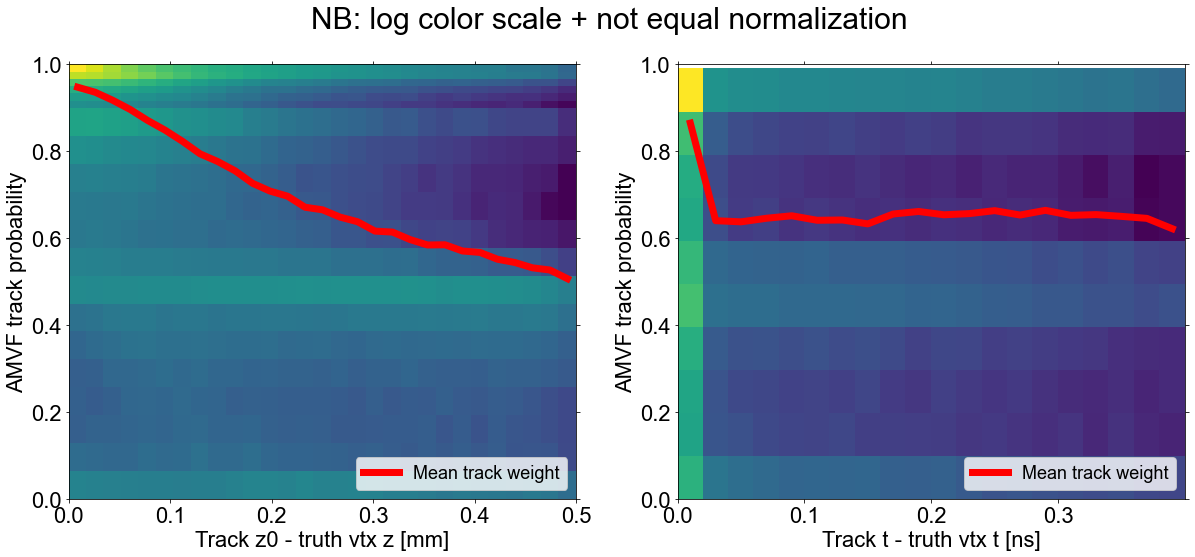

In [336]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 8)

max_z = 0.5
idx1 = np.abs(delta_z) < max_z
xbins1 = np.linspace(0, max_z, 30)
ybins1 = np.concatenate((np.linspace(0, .90, 15), np.linspace(0.90, 1, 7)))

hist = ax1.hist2d(np.abs(delta_z[idx1]), reco_vertex_HS_track_weights_flat[idx1], bins=(xbins1, ybins1), norm = mpl.colors.LogNorm())
# hist = ax1.hist2d(np.abs(delta_z[idx1]), reco_vertex_HS_track_weights_flat[idx1], bins=(30, 50))
ax1.set_ylim(0, 1)
ax1.set_xlabel('Track z0 - truth vtx z [mm]')
ax1.set_ylabel('AMVF track probability')

dz_bins = hist[1]
binned_mean_track_weight = binned_mean(np.abs(delta_z[idx1]), reco_vertex_HS_track_weights_flat[idx1], dz_bins)
ax1.plot(dz_bins[:-1]+(dz_bins[1]-dz_bins[0])/2, binned_mean_track_weight[0], 'r-', label='Mean track weight', lw=7)
ax1.legend(loc='lower right')

max_t = 0.4
idx2 = np.abs(delta_t) < max_t
xbins2 = 20
ybins2 = 10

hist2 = ax2.hist2d(np.abs(delta_t[idx2]), reco_vertex_HS_track_weights_flat[idx2], bins=(xbins2, ybins2), norm = mpl.colors.LogNorm())
# hist2 = ax2.hist2d(np.abs(delta_t[idx2]), reco_vertex_HS_track_weights_flat[idx2], bins=(30, 50))
ax2.set_ylim(0, 1)
ax2.set_xlabel('Track t - truth vtx t [ns]')
ax2.set_ylabel('AMVF track probability')

dt_bins = hist2[1]
binned_mean_track_weight = binned_mean(np.abs(delta_t[idx2]), reco_vertex_HS_track_weights_flat[idx2], dt_bins)
ax2.plot(dt_bins[:-1]+(dt_bins[1]-dt_bins[0])/2, binned_mean_track_weight[0], 'r-', label='Mean track weight', lw=7)
ax2.legend(loc='lower right')

fig.suptitle('NB: log color scale + not equal normalization', fontsize=30)
# fig.tight_layout()

#Normalize both plots in the same way - or show z axis
fig.savefig('figs/delta_z_delta_t_vs_prob_v1.pdf')

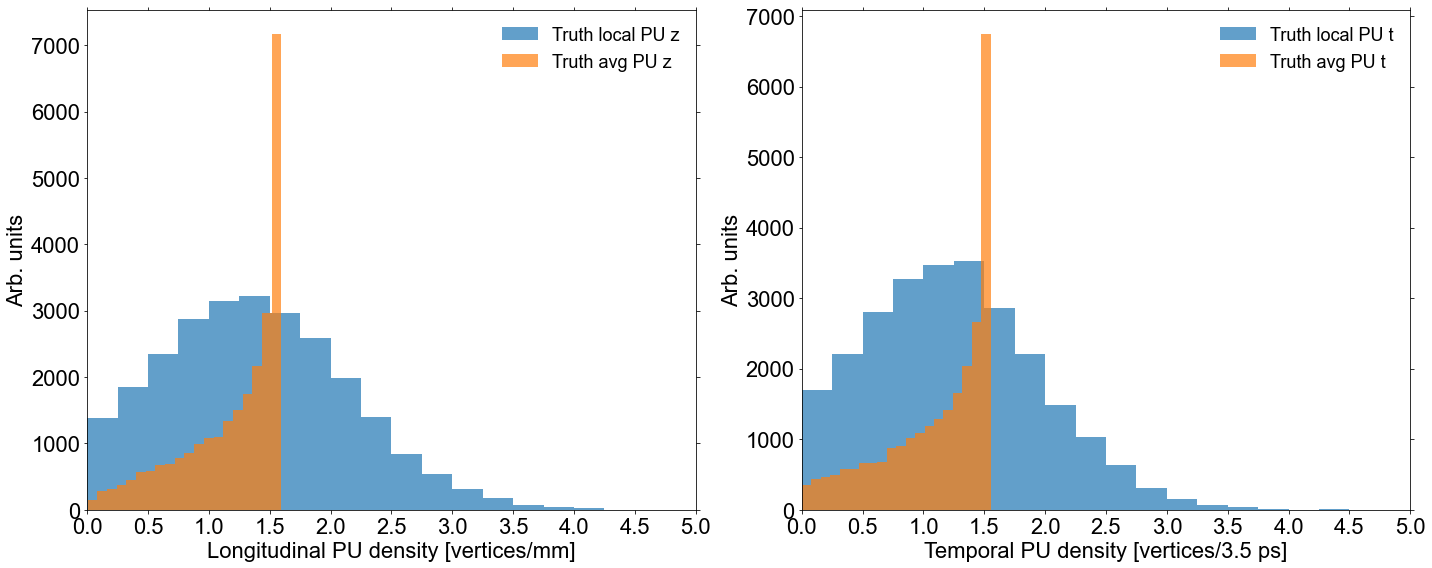

In [316]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 8)

delta_z = 2
truth_localzPU = computeLocalPUDensity(truth_vertex_z, delta_z)
truth_avgzPU = computeAvgPUDensity(truth_vertex_z, mu=200, sigma_x=50)


zbinwidth = 1/(2*delta_z)
_, zLPU_truth_bin_edges, _ = ax1.hist(truth_localzPU, bins=np.arange(np.min(truth_localzPU), np.max(truth_localzPU) + zbinwidth, zbinwidth), density=False, alpha=0.7, label='Truth local PU z')
_, zAPU_truth_bin_edges, _ = ax1.hist(truth_avgzPU, bins=20, density=False, alpha=0.7, label='Truth avg PU z')

ax1.set_xlabel('Longitudinal PU density [vertices/mm]')
ax1.set_ylabel('Arb. units')
# ax1.set_yscale('log')
ax1.set_xticks(np.arange(0, 10, 0.5))
ax1.set_xlim(0, 5)
ax1.legend(frameon=False)


sigma_t = 0.180
# delta_t = sigma_t/25
delta_t = 0.007

tPU_unit = 3.5e-3
truth_localtPU = computeLocalPUDensity(truth_vertex_t/tPU_unit, delta_t/tPU_unit)
truth_avgtPU = computeAvgPUDensity(truth_vertex_t/tPU_unit, mu=200, sigma_x=sigma_t/tPU_unit)

tbinwidth = 1/(2*delta_t/tPU_unit)
_, tLPU_truth_bin_edges, _ = ax2.hist(truth_localtPU, bins=np.arange(np.min(truth_localtPU), np.max(truth_localtPU) + tbinwidth, tbinwidth), density=False, alpha=0.7, label='Truth local PU t', color='C0')
_, tAPU_truth_bin_edges, _ = ax2.hist(truth_avgtPU, bins=20, density=False, alpha=0.7, label='Truth avg PU t', color='C1')

ax2.set_xlabel('Temporal PU density [vertices/{:.1f} ps]'.format(1e3*tPU_unit))
ax2.set_ylabel('Arb. units')
# ax2.set_yscale('log')
ax2.set_xticks(np.arange(0, 10, 0.5))
# ax2.set_xticks(np.arange(0, 0.5, 0.1))
ax2.set_xlim(0, 5)
ax2.legend(frameon=False)
fig.tight_layout()

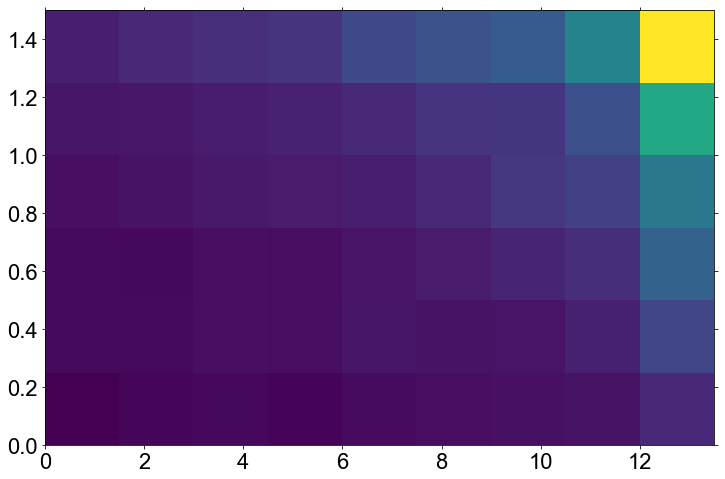

In [109]:
_= plt.hist2d(truth_avgtPU, truth_avgzPU, bins=(np.arange(0, 15, tbinwidth), np.arange(0, 1.6, zbinwidth)))


In [317]:
events_in_zLPU_bins = []
for bin in zLPU_truth_bin_edges:
    events_in_zLPU_bins.append(np.argwhere(np.isclose(truth_localzPU, bin)))
events_in_tLPU_bins = []
for bin in tLPU_truth_bin_edges:
    events_in_tLPU_bins.append(np.argwhere(np.isclose(truth_localtPU, bin)))

events_in_zAPU_bins = []
for i, bin in enumerate(zAPU_truth_bin_edges[1:]):
    events_in_zAPU_bins.append(np.argwhere(np.logical_and(truth_avgzPU > zAPU_truth_bin_edges[i-1], truth_avgzPU < bin)))
events_in_tAPU_bins = []
for i, bin in enumerate(tAPU_truth_bin_edges[1:]):
    events_in_tAPU_bins.append(np.argwhere(np.logical_and(truth_avgtPU > tAPU_truth_bin_edges[i-1], truth_avgtPU < bin)))

In [264]:
def basic_time_clustering(vertex_track_ts, n_sigma=3, maxIter=100, max_sigma_t=50e-3):
    vertex_track_ts_left = vertex_track_ts[:]
    vertex_track_idx_left = np.arange(len(vertex_track_ts))

    curr_cluster_track_ts = vertex_track_ts[:]
    curr_cluster_track_idx = np.arange(len(vertex_track_ts))

    clusters_track_t = []
    clusters_idx = []
    clusters_good = []

    converged = False
    iterations = 0
    while not converged:
        if (len(vertex_track_ts_left) == 1 and len(curr_cluster_track_ts) == 1):
            clusters_track_t.append(curr_cluster_track_ts)
            clusters_idx.append(curr_cluster_track_idx)
            clusters_good.append(False)
            break
        vtx_t = np.median(curr_cluster_track_ts)
        vtx_t_sigma = np.std(curr_cluster_track_ts, ddof=1)
        vtx_t_sigma = np.min((vtx_t_sigma, max_sigma_t))

        inside_t_local_idx = np.abs(curr_cluster_track_ts - vtx_t) <= vtx_t_sigma*n_sigma
        inside_t = curr_cluster_track_ts[inside_t_local_idx]

        # no tracks in current cluster outside x sigma
        if len(inside_t) == len(curr_cluster_track_ts):
            iterations = 0
            clusters_track_t.append(curr_cluster_track_ts)
            clusters_idx.append(curr_cluster_track_idx)
            clusters_good.append(True)

            # remove tracks from pool
            tracks_to_keep_local_idx = np.where(np.isin(vertex_track_idx_left, curr_cluster_track_idx, invert=True))
            vertex_track_ts_left = vertex_track_ts_left[tracks_to_keep_local_idx]
            vertex_track_idx_left = vertex_track_idx_left[tracks_to_keep_local_idx]
            
            curr_cluster_track_ts = vertex_track_ts_left
            curr_cluster_track_idx = vertex_track_idx_left
            
            if len(vertex_track_idx_left) == 0:
                converged = True
        # do sigma cut
        else:
            iterations += 1
            curr_cluster_track_ts = curr_cluster_track_ts[inside_t_local_idx]
            curr_cluster_track_idx = curr_cluster_track_idx[inside_t_local_idx]
            if len(curr_cluster_track_ts) == 0:
                curr_cluster_track_ts = vertex_track_ts_left
                curr_cluster_track_idx = vertex_track_idx_left

        if iterations > maxIter:
            # print('maxIter hit')
            clusters_track_t.append(curr_cluster_track_ts)
            clusters_idx.append(curr_cluster_track_idx)
            clusters_good.append(False)

            # remove tracks from pool
            tracks_to_keep_local_idx = np.where(np.isin(vertex_track_idx_left, curr_cluster_track_idx, invert=True))
            vertex_track_ts_left = vertex_track_ts_left[tracks_to_keep_local_idx]
            vertex_track_idx_left = vertex_track_idx_left[tracks_to_keep_local_idx]
            
            curr_cluster_track_ts = vertex_track_ts_left
            curr_cluster_track_idx = vertex_track_idx_left
            
            if len(vertex_track_idx_left) == 0:
                converged = True
            
    return clusters_track_t, clusters_idx, clusters_good

In [265]:
def gaussian_no_bkg(x, ampl, mean, sd):
    return gaussian(x, ampl, mean, sd, 0)
def gaussian_fit(delta_x, sigma_0, bin_width):
    ## Do a sigma cut on the data first
    n_sigma = 3
    delta_x = np.array(delta_x)[np.abs(delta_x) < n_sigma*np.std(delta_x, ddof=1)]

    # bins = np.arange(np.min(delta_x)-bin_width, np.max(delta_x)+bin_width, bin_width)
    bins = np.ceil(2*len(delta_x)**(1/3))*2
    bin_heights, bin_borders = np.histogram(delta_x, bins=int(bins))

    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

    ysigma = np.sqrt(bin_heights) + 1*(bin_heights == 0)
    p0 = (np.max(bin_heights)*0.8, 0., sigma_0)
    popt = np.array([np.nan, np.nan, np.nan])
    pcov = np.empty((3,3,))
    pcov[:] = np.nan
    try:
        popt, pcov = curve_fit(gaussian_no_bkg, bin_centers, bin_heights, sigma=ysigma, absolute_sigma=True, p0=p0)
    except:
        try:
            bins = np.arange(np.min(delta_x)-bin_width*2, np.max(delta_x)+bin_width*2, 2*bin_width) 
            bin_heights, bin_borders = np.histogram(delta_x, bins=bins)

            bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

            ysigma = np.sqrt(bin_heights) + 1*(bin_heights == 0)
            p0 = (np.max(bin_heights)*0.8, 0., 2*sigma_0)
            popt, pcov = curve_fit(gaussian_no_bkg, bin_centers, bin_heights, sigma=ysigma, absolute_sigma=True, p0=p0)
        except:
            print('Fit failed')
    return popt, pcov

In [266]:
def bootstrap_rms_std(x, n=1000):
    bootstrap_x_rms = []
    for _ in range(n):
        x_idx = np.random.randint(0, len(x), len(x))
        bootstrap_x_rms.append(np.sqrt(np.mean(np.array(x)[x_idx]**2)))
    return np.std(bootstrap_x_rms, ddof=1)

def vtx_time_info(events_in_bins, truth_vtx_idx_in_bins, all_truth_vtx_t, reco_vtx_idx_in_bins, all_reco_track_idxs, all_reco_track_weights, all_track_t, all_track_t_var, all_track_pT, sigma_cut, weight_cut, pT_cut):
    ## Track delta ts
    track_delta_t = []
    track_delta_t_rms = []
    track_weight_cut_delta_t = []
    track_weight_cut_delta_t_rms = []
    track_sigma_cut_delta_t = []
    track_sigma_cut_delta_t_rms = []
    track_4highest_pT_delta_t = []
    track_4highest_pT_delta_t_rms = []
    
    ## Track based vtx resolution
    track_vtx_t_rms = []
    track_vtx_t_rms_std = []
    track_vtx_t_rms_weight_cut = []
    track_vtx_t_rms_std_weight_cut = []
    track_vtx_t_rms_sigma_cut = []
    track_vtx_t_rms_std_sigma_cut = []
    track_vtx_4highest_pT_t_rms = []
    track_vtx_4highest_pT_t_rms_std = []

    ## Vertex estimator delta ts
    vtx_delta_t = []
    vtx_weighted_delta_t = []
    vtx_weight_cut_delta_t = []
    vtx_sigma_cut_weighted_delta_t = []
    
    vtx_pT_cut_delta_t = []
    vtx_4highest_pT_delta_t = []
    vtx_4highest_pT_weight_cut_delta_t = []
    vtx_4highest_weight_delta_t = []

    ## Vertex t estimator based vtx resolution 
    vtx_t_rms = []
    vtx_weighted_t_rms = []
    vtx_weight_cut_t_rms = []
    vtx_weight_cut_weighted_t_rms = []
    vtx_sigma_cut_weighted_t_rms = []
    vtx_t_rms_tracks_sigma_cut = []
    vtx_weighted_t_rms_tracks_sigma_cut = []

    vtx_pT_cut_t_rms = []
    vtx_4highest_pT_weight_cut_t_rms = []
    vtx_4highest_weight_t_rms = []
    vtx_4highest_pT_t_rms = []
    vtx_4highest_pT_t_rms_sigma_cut = []

    ## Vertex t estimator based vtx resolution std deviation
    vtx_t_rms_std = []
    vtx_weighted_t_rms_std = []
    vtx_weight_cut_t_rms_std = []
    vtx_weight_cut_weighted_t_rms_std = []
    vtx_sigma_cut_weighted_t_rms_std = []
    vtx_t_rms_std_tracks_sigma_cut = []
    vtx_weighted_t_rms_std_tracks_sigma_cut = []

    vtx_pT_cut_t_rms_std = []
    vtx_4highest_pT_weight_cut_t_rms_std = []
    vtx_4highest_weight_t_rms_std = []
    vtx_4highest_pT_t_rms_std = []
    vtx_4highest_pT_t_rms_std_sigma_cut = []

    ## t resolution from clustering
    cluster_vtx_delta_t = []
    cluster_vtx_t_rms = []
    cluster_vtx_t_rms_std = []
    cluster_vtx_t_gaussian_std = []
    cluster_vtx_t_gaussian_std_std = []
    cluster_avg_n_PUvxts = []

    ## Avg reco vertex track multiplicity 
    avg_n_tracks = []
    avg_n_tracks_weight_cut = []
    avg_n_tracks_sigma_cut = []

    for event_idxs, truth_vtx_idxs, reco_vtx_idxs in zip(events_in_bins, truth_vtx_idx_in_bins, reco_vtx_idx_in_bins):
        bin_track_delta_t = np.array([])
        bin_track_delta_t_rms = []
        
        bin_track_4highest_pT_delta_t = np.array([])
        bin_track_4highest_pT_delta_t_rms = []

        bin_vtx_delta_t = []
        bin_vtx_weighted_delta_t = []
        
        bin_track_weight_cut_delta_t = np.array([])
        bin_track_weight_cut_delta_t_rms = []
        
        bin_vtx_weight_cut_delta_t = []
        bin_vtx_weight_cut_weighted_delta_t = []
        
        bin_vtx_pT_cut_delta_t = []
        bin_vtx_4highest_pT_delta_t = []
        bin_vtx_4highest_pT_weight_cut_delta_t = []
        bin_vtx_4highest_weight_delta_t = []

        bin_reco_n_tracks = []
        bin_reco_n_tracks_weight_cut = []

        ## Clustering
        bin_cluster_vtx_delta_t = []
        bin_cluster_n_PUvxts = []
        
        for idx, truth_idx, reco_idx in zip(event_idxs, truth_vtx_idxs, reco_vtx_idxs):
            if reco_idx == -1: continue
            if truth_idx == -1: continue
            idx = idx[0]
            reco_track_t = all_track_t[idx][all_reco_track_idxs[idx][reco_idx]]
            reco_track_clean_idx = np.logical_and(reco_track_t != -1e3, reco_track_t != -1e6)
            reco_track_t = reco_track_t[reco_track_clean_idx]
            # reco_track_weights = all_reco_track_weights[idx][reco_idx][reco_track_t_clean_idx]
            reco_track_t_var = all_track_t_var[idx][all_reco_track_idxs[idx][reco_idx]][reco_track_clean_idx]
            reco_track_weights = all_reco_track_weights[idx][reco_idx][reco_track_clean_idx] 
            reco_track_pT = all_track_pT[idx][all_reco_track_idxs[idx][reco_idx]][reco_track_clean_idx]

            bin_reco_n_tracks.append(len(reco_track_t))
            
            truth_t = all_truth_vtx_t[idx][truth_idx]
            event_track_delta_t = reco_track_t - truth_t
            
            bin_track_delta_t = np.concatenate((bin_track_delta_t, event_track_delta_t))
            bin_track_delta_t_rms.append(np.sqrt(np.mean(event_track_delta_t**2)))
            
            reco_vtx_t = np.mean(reco_track_t)
            reco_vtx_weighted_t = np.average(reco_track_t, weights=reco_track_weights/reco_track_t_var)
            
            bin_vtx_delta_t.append(reco_vtx_t - truth_t)
            bin_vtx_weighted_delta_t.append(reco_vtx_weighted_t - truth_t)
            
            # Weight cut
            weight_cut_idx = np.array(reco_track_weights) > weight_cut
            if np.sum(weight_cut_idx) > 0:
                weight_cut_track_t = reco_track_t[weight_cut_idx]
                bin_reco_n_tracks_weight_cut.append(len(weight_cut_track_t))
                
                weight_cut_event_delta_t = weight_cut_track_t - truth_t
            
                bin_track_weight_cut_delta_t = np.concatenate((bin_track_weight_cut_delta_t, weight_cut_event_delta_t))
                bin_track_weight_cut_delta_t_rms.append(np.sqrt(np.mean(weight_cut_event_delta_t**2)))
                
                weight_cut_vtx_t = np.mean(weight_cut_track_t)
                weight_cut_vtx_weighted_t = np.average(weight_cut_track_t, weights = reco_track_weights[weight_cut_idx]/reco_track_t_var[weight_cut_idx])
                
                bin_vtx_weight_cut_delta_t.append(weight_cut_vtx_t - truth_t)
                bin_vtx_weight_cut_weighted_delta_t.append(weight_cut_vtx_weighted_t - truth_t)
                
                ## Weight cut highest pT vtx t estimator
                if np.sum(weight_cut_idx) >= 4: 
                    weight_cut_highest_pT_track_idx = np.argpartition(reco_track_pT[weight_cut_idx], -4)[-4:]
                    bin_vtx_4highest_pT_weight_cut_delta_t.append(np.average(reco_track_t[weight_cut_idx][weight_cut_highest_pT_track_idx],\
                                weights=reco_track_weights[weight_cut_idx][weight_cut_highest_pT_track_idx]/reco_track_t_var[weight_cut_idx][weight_cut_highest_pT_track_idx]) - truth_t)
            
            ## pT cut vtx t estimators
            pT_cut_idx = reco_track_pT > pT_cut
            if np.sum(pT_cut_idx) > 0:
                reco_vtx_t_pT_cut = np.average(reco_track_t[pT_cut_idx], weights=reco_track_weights[pT_cut_idx]/reco_track_t_var[pT_cut_idx])
                bin_vtx_pT_cut_delta_t.append(reco_vtx_t_pT_cut - truth_t)

            if len(reco_track_t) >= 4:
                highest_pT_track_idx = np.argpartition(reco_track_pT, -4)[-4:]
                bin_vtx_4highest_pT_delta_t.append(np.average(reco_track_t[highest_pT_track_idx],\
                    weights=reco_track_weights[highest_pT_track_idx]/reco_track_t_var[highest_pT_track_idx]) - truth_t)

                bin_track_4highest_pT_delta_t = np.concatenate((bin_track_4highest_pT_delta_t, reco_track_t[highest_pT_track_idx] - truth_t))
                bin_track_4highest_pT_delta_t_rms.append(np.sqrt(np.mean((reco_track_t[highest_pT_track_idx] - truth_t)**2)))

                ## Highest weight vtx t estimator
                highest_weight_track_idx = np.argpartition(reco_track_weights, -4)[-4:]
                bin_vtx_4highest_weight_delta_t.append(np.average(reco_track_t[highest_weight_track_idx],\
                    weights=reco_track_weights[highest_weight_track_idx]/reco_track_t_var[highest_weight_track_idx]) - truth_t)
            
            ## Clustering
            clusters_ts, clusters_idxs, clusters_good = basic_time_clustering(reco_track_t)
            clusters_sumpt2 = [np.sum(reco_track_pT[single_cluster_idxs]**2) for single_cluster_idxs in clusters_idxs]
            if clusters_good[np.argmax(clusters_sumpt2)]:
                main_cluster_ts = clusters_ts[np.argmax(clusters_sumpt2)]
                main_cluster_vtx_t = np.mean(main_cluster_ts)
                bin_cluster_vtx_delta_t.append(main_cluster_vtx_t - truth_t)
                bin_cluster_n_PUvxts.append(len(clusters_ts) - 1)
        
        avg_n_tracks.append(np.mean(bin_reco_n_tracks))
        avg_n_tracks_weight_cut.append(np.mean(bin_reco_n_tracks_weight_cut))
        
        track_delta_t.append(bin_track_delta_t)
        track_delta_t_rms.append(bin_track_delta_t_rms)
        track_weight_cut_delta_t.append(bin_track_weight_cut_delta_t)
        track_weight_cut_delta_t_rms.append(bin_track_weight_cut_delta_t_rms)
        
        track_vtx_t_rms.append(np.mean(bin_track_delta_t_rms / np.sqrt(np.array(bin_reco_n_tracks))))
        track_vtx_t_rms_std.append(np.std(bin_track_delta_t_rms / np.sqrt(np.array(bin_reco_n_tracks)), ddof=1)/np.sqrt(len(bin_reco_n_tracks)))
        track_vtx_t_rms_weight_cut.append(np.mean(bin_track_weight_cut_delta_t_rms / np.sqrt(np.array(bin_reco_n_tracks_weight_cut))))
        track_vtx_t_rms_std_weight_cut.append(np.std(bin_track_weight_cut_delta_t_rms / np.sqrt(np.array(bin_reco_n_tracks_weight_cut)), ddof=1)/np.sqrt(len(bin_track_weight_cut_delta_t_rms)))
        
        track_vtx_4highest_pT_t_rms.append(np.mean(bin_track_4highest_pT_delta_t_rms / np.sqrt(4)))
        track_vtx_4highest_pT_t_rms_std.append(np.std(bin_track_4highest_pT_delta_t_rms / np.sqrt(4), ddof=1)/np.sqrt(len(bin_track_4highest_pT_delta_t_rms)))
        
        vtx_delta_t.append(bin_vtx_delta_t)
        vtx_weighted_delta_t.append(bin_vtx_weighted_delta_t)
        vtx_weight_cut_delta_t.append(bin_vtx_weight_cut_delta_t)
        
        vtx_t_rms.append(np.sqrt(np.mean(np.array(bin_vtx_delta_t)**2)))
        vtx_weighted_t_rms.append(np.sqrt(np.mean(np.array(bin_vtx_weighted_delta_t)**2)))
        vtx_weight_cut_t_rms.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_delta_t)**2)))
        vtx_weight_cut_weighted_t_rms.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_weighted_delta_t)**2)))
        
        vtx_pT_cut_delta_t.append(bin_vtx_pT_cut_delta_t)
        vtx_4highest_pT_delta_t.append(bin_vtx_4highest_pT_delta_t)
        vtx_4highest_pT_weight_cut_delta_t.append(bin_vtx_4highest_pT_weight_cut_delta_t)
        vtx_4highest_weight_delta_t.append(bin_vtx_4highest_weight_delta_t)
        
        vtx_pT_cut_t_rms.append(np.sqrt(np.mean(np.array(bin_vtx_pT_cut_delta_t)**2)))
        vtx_4highest_pT_t_rms.append(np.sqrt(np.mean(np.array(bin_vtx_4highest_pT_delta_t)**2)))
        vtx_4highest_pT_weight_cut_t_rms.append(np.sqrt(np.mean(np.array(bin_vtx_4highest_pT_weight_cut_delta_t)**2)))
        vtx_4highest_weight_t_rms.append(np.sqrt(np.mean(np.array(bin_vtx_4highest_weight_delta_t)**2)))

        ## Sigma cutting on the vtx delta t distribution
        bin_vtx_weighted_delta_t_sigma = np.std(bin_vtx_weighted_delta_t, ddof=1)
        bin_vtx_delta_t_sigma_cut_idxs = np.abs(bin_vtx_weighted_delta_t - np.mean(bin_vtx_weighted_delta_t)) < sigma_cut*bin_vtx_weighted_delta_t_sigma
        vtx_sigma_cut_weighted_delta_t.append(np.array(bin_vtx_weighted_delta_t)[bin_vtx_delta_t_sigma_cut_idxs])
        vtx_sigma_cut_weighted_t_rms.append(np.sqrt(np.mean(np.array(bin_vtx_weighted_delta_t)[bin_vtx_delta_t_sigma_cut_idxs]**2)))

        bin_vtx_4highest_pT_delta_t_sigma = np.std(bin_vtx_4highest_pT_delta_t, ddof=1)
        bin_vtx_4highest_pT_delta_t_sigma_cut_idx = np.abs(bin_vtx_4highest_pT_delta_t - np.mean(bin_vtx_4highest_pT_delta_t)) < sigma_cut*bin_vtx_4highest_pT_delta_t_sigma
        vtx_4highest_pT_t_rms_sigma_cut.append(np.sqrt(np.mean(np.array(bin_vtx_4highest_pT_delta_t)[bin_vtx_4highest_pT_delta_t_sigma_cut_idx]**2)))

        ## Clustering
        cluster_vtx_delta_t.append(bin_cluster_vtx_delta_t)
        cluster_vtx_t_rms.append(np.sqrt(np.mean(np.array(bin_cluster_vtx_delta_t)**2)))
        cluster_vtx_t_rms_std.append(bootstrap_rms_std(bin_cluster_vtx_delta_t))
        cluster_avg_n_PUvxts.append(np.mean(bin_cluster_n_PUvxts))
        if len(bin_cluster_vtx_delta_t) > 4:
            popt, pcov = gaussian_fit(bin_cluster_vtx_delta_t, 10e-3, 1e-3)
            cluster_vtx_t_gaussian_std.append(popt[2])
            cluster_vtx_t_gaussian_std_std.append(pcov[2,2]**0.5)
        else:
            cluster_vtx_t_gaussian_std.append(np.nan)
            cluster_vtx_t_gaussian_std_std.append(np.nan)

        ## Sigma cutting on tracks both for track based estimate on vtx t res and estimator of vtx t 
        bin_track_sigma = np.std(bin_track_delta_t)
        bin_track_sigma_cut_delta_t = np.array([])
        bin_track_sigma_cut_delta_t_rms = []
        bin_reco_n_tracks_sigma_cut = []
        
        bin_vtx_delta_t_tracks_sigma_cut = []
        bin_vtx_weighted_delta_t_tracks_sigma_cut = []
        
        for idx, truth_idx, reco_idx in zip(event_idxs, truth_vtx_idxs, reco_vtx_idxs):
            if reco_idx == -1: continue
            if truth_idx == -1: continue
            idx = idx[0]
            reco_track_t = all_track_t[idx][all_reco_track_idxs[idx][reco_idx]]
            reco_track_t_clean_idx = np.logical_and(reco_track_t != -1e3, reco_track_t != -1e6)
            reco_track_t = reco_track_t[np.logical_and(reco_track_t != -1e3, reco_track_t != -1e6)]
            # reco_track_weights = all_reco_track_weights[idx][reco_idx][reco_track_t_clean_idx]
            reco_track_weights = all_reco_track_weights[idx][reco_idx][reco_track_t_clean_idx]
            reco_track_t_var = all_track_t_var[idx][all_reco_track_idxs[idx][reco_idx]][reco_track_t_clean_idx]
            
            truth_t = all_truth_vtx_t[idx][truth_idx]
            event_track_delta_t = reco_track_t - truth_t
            
            track_sigma_cut_idx = np.abs(event_track_delta_t - np.mean(event_track_delta_t)) < sigma_cut*bin_track_sigma
            if np.sum(track_sigma_cut_idx) > 0:
                event_track_delta_t_sigma_cut = event_track_delta_t[track_sigma_cut_idx]
                
                bin_track_sigma_cut_delta_t = np.concatenate((bin_track_sigma_cut_delta_t, event_track_delta_t_sigma_cut))
                bin_track_sigma_cut_delta_t_rms.append(np.sqrt(np.mean(event_track_delta_t_sigma_cut**2)))
                bin_reco_n_tracks_sigma_cut.append(len(event_track_delta_t_sigma_cut))
                
                reco_vtx_t_sigma_cut_tracks = np.mean(reco_track_t[track_sigma_cut_idx])
                reco_vtx_weighted_t_sigma_cut_tracks = np.average(reco_track_t[track_sigma_cut_idx], weights=reco_track_weights[track_sigma_cut_idx]/reco_track_t_var[track_sigma_cut_idx])
                
                bin_vtx_delta_t_tracks_sigma_cut.append(reco_vtx_t_sigma_cut_tracks - truth_t)
                bin_vtx_weighted_delta_t_tracks_sigma_cut.append(reco_vtx_weighted_t_sigma_cut_tracks - truth_t)
        
        track_sigma_cut_delta_t.append(bin_track_sigma_cut_delta_t)
        track_sigma_cut_delta_t_rms.append(bin_track_sigma_cut_delta_t_rms)
        track_vtx_t_rms_sigma_cut.append(np.mean(bin_track_sigma_cut_delta_t_rms / np.sqrt(np.array(bin_reco_n_tracks_sigma_cut))))
        track_vtx_t_rms_std_sigma_cut.append(np.std(bin_track_sigma_cut_delta_t_rms / np.sqrt(np.array(bin_reco_n_tracks_sigma_cut)), ddof=1)/np.sqrt(len(bin_reco_n_tracks_sigma_cut)))
        
        vtx_t_rms_tracks_sigma_cut.append(np.sqrt(np.mean(np.array(bin_vtx_delta_t_tracks_sigma_cut)**2)))
        vtx_weighted_t_rms_tracks_sigma_cut.append(np.sqrt(np.mean(np.array(bin_vtx_weighted_delta_t_tracks_sigma_cut)**2)))
        
        # Compute bootstrap std deviations
        bootstrap_n = 1000
        vtx_t_rms_std.append(bootstrap_rms_std(bin_vtx_delta_t, bootstrap_n))
        vtx_weighted_t_rms_std.append(bootstrap_rms_std(bin_vtx_weighted_delta_t, bootstrap_n))
        vtx_weight_cut_t_rms_std.append(bootstrap_rms_std(bin_vtx_weight_cut_delta_t, bootstrap_n))
        vtx_weight_cut_weighted_t_rms_std.append(bootstrap_rms_std(bin_vtx_weight_cut_weighted_delta_t, bootstrap_n))
        vtx_sigma_cut_weighted_t_rms_std.append(bootstrap_rms_std(np.array(bin_vtx_weighted_delta_t)[bin_vtx_delta_t_sigma_cut_idxs], bootstrap_n))
        vtx_t_rms_std_tracks_sigma_cut.append(bootstrap_rms_std(bin_vtx_delta_t_tracks_sigma_cut, bootstrap_n))
        vtx_weighted_t_rms_std_tracks_sigma_cut.append(bootstrap_rms_std(bin_vtx_weighted_delta_t_tracks_sigma_cut, bootstrap_n))

        vtx_pT_cut_t_rms_std.append(bootstrap_rms_std(bin_vtx_pT_cut_delta_t, bootstrap_n))
        vtx_4highest_pT_t_rms_std.append(bootstrap_rms_std(bin_vtx_4highest_pT_delta_t, bootstrap_n))
        vtx_4highest_pT_weight_cut_t_rms_std.append(bootstrap_rms_std(bin_vtx_4highest_pT_weight_cut_delta_t, bootstrap_n))
        vtx_4highest_weight_t_rms_std.append(bootstrap_rms_std(bin_vtx_4highest_weight_delta_t, bootstrap_n))
        vtx_4highest_pT_t_rms_std_sigma_cut.append(bootstrap_rms_std(np.array(bin_vtx_4highest_pT_delta_t)[bin_vtx_4highest_pT_delta_t_sigma_cut_idx], bootstrap_n))
        
    return  {
                'avg_n_tracks' : avg_n_tracks,
                'track_delta_t' : track_delta_t,
                'track_delta_t_rms' : track_delta_t_rms,
                'track_weight_cut_delta_t' : track_weight_cut_delta_t,
                'track_weight_cut_delta_t_rms' : track_weight_cut_delta_t_rms,
                'track_sigma_cut_delta_t' : track_sigma_cut_delta_t,
                'track_sigma_cut_delta_t_rms' : track_sigma_cut_delta_t_rms,
                'track_vtx_t_rms' : track_vtx_t_rms,
                'track_vtx_t_rms_weight_cut' : track_vtx_t_rms_weight_cut,
                'track_vtx_t_rms_sigma_cut' : track_vtx_t_rms_sigma_cut,
                'vtx_delta_t' : vtx_delta_t,
                'vtx_weighted_delta_t' : vtx_weighted_delta_t,
                'vtx_weight_cut_delta_t' : vtx_weight_cut_delta_t,
                'vtx_sigma_cut_weighted_delta_t' : vtx_sigma_cut_weighted_delta_t,
                'vtx_t_rms' : vtx_t_rms,
                'vtx_weighted_t_rms' : vtx_weighted_t_rms,
                'vtx_weight_cut_t_rms' : vtx_weight_cut_t_rms,
                'vtx_weight_cut_weighted_t_rms' : vtx_weight_cut_weighted_t_rms,
                'vtx_sigma_cut_weighted_t_rms' : vtx_sigma_cut_weighted_t_rms,
                'vtx_sigma_cut_weighted_t_rms_std' : vtx_sigma_cut_weighted_t_rms_std,
                'vtx_t_rms_tracks_sigma_cut' : vtx_t_rms_tracks_sigma_cut,
                'vtx_weighted_t_rms_tracks_sigma_cut' : vtx_weighted_t_rms_tracks_sigma_cut,
                'track_vtx_t_rms_std' : track_vtx_t_rms_std,
                'track_vtx_t_rms_std_weight_cut' : track_vtx_t_rms_std_weight_cut,
                'track_vtx_t_rms_std_sigma_cut' : track_vtx_t_rms_std_sigma_cut,
                'vtx_t_rms_std' : vtx_t_rms_std,
                'vtx_weighted_t_rms_std' : vtx_weighted_t_rms_std,
                'vtx_weight_cut_t_rms_std' : vtx_weight_cut_t_rms_std,
                'vtx_weight_cut_weighted_t_rms_std' : vtx_weight_cut_weighted_t_rms_std,
                'vtx_t_rms_std_tracks_sigma_cut' : vtx_t_rms_std_tracks_sigma_cut,
                'vtx_weighted_t_rms_std_tracks_sigma_cut' : vtx_weighted_t_rms_std_tracks_sigma_cut,
                
                'vtx_pT_cut_delta_t' : vtx_pT_cut_delta_t,
                'vtx_4highest_pT_delta_t' : vtx_4highest_pT_delta_t,
                'vtx_4highest_pT_weight_cut_delta_t' : vtx_4highest_pT_weight_cut_delta_t,
                'vtx_4highest_weight_delta_t' : vtx_4highest_weight_delta_t,
                
                'vtx_pT_cut_t_rms' : vtx_pT_cut_t_rms,
                'vtx_4highest_pT_weight_cut_t_rms' : vtx_4highest_pT_weight_cut_t_rms,
                'vtx_4highest_weight_t_rms' : vtx_4highest_weight_t_rms,
                'vtx_4highest_pT_t_rms' : vtx_4highest_pT_t_rms,
                'vtx_4highest_pT_t_rms_sigma_cut' : vtx_4highest_pT_t_rms_sigma_cut,

                'vtx_pT_cut_t_rms_std' : vtx_pT_cut_t_rms_std,
                'vtx_4highest_pT_weight_cut_t_rms_std' : vtx_4highest_pT_weight_cut_t_rms_std,
                'vtx_4highest_weight_t_rms_std' : vtx_4highest_weight_t_rms_std,
                'vtx_4highest_pT_t_rms_std' : vtx_4highest_pT_t_rms_std,
                'vtx_4highest_pT_t_rms_std_sigma_cut' : vtx_4highest_pT_t_rms_std_sigma_cut,

                'track_4highest_pT_delta_t' : track_4highest_pT_delta_t,
                'track_4highest_pT_delta_t_rms' : track_4highest_pT_delta_t_rms,
                'track_vtx_4highest_pT_t_rms' : track_vtx_4highest_pT_t_rms,
                'track_vtx_4highest_pT_t_rms_std' : track_vtx_4highest_pT_t_rms_std,

                'cluster_vtx_delta_t' : cluster_vtx_delta_t,
                'cluster_vtx_t_rms' : cluster_vtx_t_rms,
                'cluster_vtx_t_rms_std' : cluster_vtx_t_rms_std,
                'cluster_avg_n_PUvxts' : cluster_avg_n_PUvxts,
                'cluster_vtx_t_gaussian_std' : cluster_vtx_t_gaussian_std,
                'cluster_vtx_t_gaussian_std_std' : cluster_vtx_t_gaussian_std_std,
                
            }

def vtx_time_info_cleanup(events_in_bins, truth_vtx_idx_in_bins, all_truth_vtx_t, reco_vtx_idx_in_bins,\
    all_reco_track_idxs, all_reco_track_weights, all_track_t, all_track_t_var, all_track_pT, sigma_cut,\
    weight_cut, pT_cut, sigma_t=10e-3, t_bin_res=2e-3, cluster_max_sigma=50e-3):
    
    ## Track delta ts
    track_delta_t = []
    track_delta_t_rms = []
    track_weight_cut_delta_t = []
    track_weight_cut_delta_t_rms = []
    track_4highest_pT_delta_t = []
    track_4highest_pT_delta_t_rms = []
    
    ## Vertex estimator delta ts
    vtx_delta_t = []
    vtx_weighted_delta_t = []
    vtx_weight_cut_delta_t = []
    
    vtx_pT_cut_delta_t = []
    vtx_4highest_pT_delta_t = []
    vtx_4highest_pT_weight_cut_delta_t = []
    vtx_4highest_weight_delta_t = []

    ## Vertex t estimator based vtx resolution 
    vtx_t_rms = []
    vtx_t_rms_std = []
    vtx_t_gaussian_std = []
    vtx_t_gaussian_std_std = []

    vtx_weighted_t_rms = []
    vtx_weighted_t_rms_std = []
    vtx_weighted_t_gaussian_std = []
    vtx_weighted_t_gaussian_std_std = []

    vtx_weight_cut_t_rms = []
    vtx_weight_cut_t_rms_std = []
    vtx_weight_cut_t_gaussian_std = []
    vtx_weight_cut_t_gaussian_std_std = []

    vtx_4highest_pT_t_rms = []
    vtx_4highest_pT_t_rms_std = []
    vtx_4highest_pT_t_gaussian_std = []
    vtx_4highest_pT_t_gaussian_std_std = []

    vtx_weight_cut_weighted_t_rms = []
    vtx_weight_cut_weighted_t_rms_std = []

    vtx_pT_cut_t_rms = []
    vtx_pT_cut_t_rms_std = []

    vtx_4highest_weight_t_rms = []
    vtx_4highest_weight_t_rms_std = []


    ## t resolution from clustering
    cluster_vtx_delta_t = []
    cluster_vtx_t_rms = []
    cluster_vtx_t_rms_std = []
    cluster_vtx_t_gaussian_std = []
    cluster_vtx_t_gaussian_std_std = []
    cluster_avg_n_PUvxts = []
    cluster_efficiency = []

    ## Avg reco vertex track multiplicity 
    avg_n_tracks = []
    avg_n_tracks_weight_cut = []

    for event_idxs, truth_vtx_idxs, reco_vtx_idxs in zip(events_in_bins, truth_vtx_idx_in_bins, reco_vtx_idx_in_bins):
        bin_track_delta_t = np.array([])
        bin_track_delta_t_rms = []
        
        bin_track_4highest_pT_delta_t = np.array([])
        bin_track_4highest_pT_delta_t_rms = []

        bin_vtx_delta_t = []
        bin_vtx_weighted_delta_t = []
        
        bin_track_weight_cut_delta_t = np.array([])
        bin_track_weight_cut_delta_t_rms = []
        
        bin_vtx_weight_cut_delta_t = []
        bin_vtx_weight_cut_weighted_delta_t = []
        
        bin_vtx_pT_cut_delta_t = []
        bin_vtx_4highest_pT_delta_t = []
        bin_vtx_4highest_weight_delta_t = []

        bin_reco_n_tracks = []
        bin_reco_n_tracks_weight_cut = []

        ## Clustering
        bin_cluster_vtx_delta_t = []
        bin_cluster_n_PUvxts = []
        bin_cluster_n_good = 0
        n_events = 0
        
        for idx, truth_idx, reco_idx in zip(event_idxs, truth_vtx_idxs, reco_vtx_idxs):
            if reco_idx == -1: continue
            if truth_idx == -1: continue
            idx = idx[0]
            reco_track_t = all_track_t[idx][all_reco_track_idxs[idx][reco_idx]]
            reco_track_clean_idx = np.logical_and(reco_track_t != -1e3, reco_track_t != -1e6)
            reco_track_t = reco_track_t[reco_track_clean_idx]
            # reco_track_weights = all_reco_track_weights[idx][reco_idx][reco_track_t_clean_idx]
            reco_track_t_var = all_track_t_var[idx][all_reco_track_idxs[idx][reco_idx]][reco_track_clean_idx]
            reco_track_weights = all_reco_track_weights[idx][reco_idx][reco_track_clean_idx] 
            reco_track_pT = all_track_pT[idx][all_reco_track_idxs[idx][reco_idx]][reco_track_clean_idx]

            bin_reco_n_tracks.append(len(reco_track_t))
            
            truth_t = all_truth_vtx_t[idx][truth_idx]
            event_track_delta_t = reco_track_t - truth_t
            
            bin_track_delta_t = np.concatenate((bin_track_delta_t, event_track_delta_t))
            bin_track_delta_t_rms.append(np.sqrt(np.mean(event_track_delta_t**2)))
            
            reco_vtx_t = np.mean(reco_track_t)
            reco_vtx_weighted_t = np.average(reco_track_t, weights=reco_track_weights/reco_track_t_var)
            
            bin_vtx_delta_t.append(reco_vtx_t - truth_t)
            bin_vtx_weighted_delta_t.append(reco_vtx_weighted_t - truth_t)
            
            # Weight cut
            weight_cut_idx = np.array(reco_track_weights) > weight_cut
            if np.sum(weight_cut_idx) > 0:
                weight_cut_track_t = reco_track_t[weight_cut_idx]
                bin_reco_n_tracks_weight_cut.append(len(weight_cut_track_t))
                
                weight_cut_event_delta_t = weight_cut_track_t - truth_t
            
                bin_track_weight_cut_delta_t = np.concatenate((bin_track_weight_cut_delta_t, weight_cut_event_delta_t))
                bin_track_weight_cut_delta_t_rms.append(np.sqrt(np.mean(weight_cut_event_delta_t**2)))
                
                weight_cut_vtx_t = np.mean(weight_cut_track_t)
                weight_cut_vtx_weighted_t = np.average(weight_cut_track_t, weights = reco_track_weights[weight_cut_idx]/reco_track_t_var[weight_cut_idx])
                
                bin_vtx_weight_cut_delta_t.append(weight_cut_vtx_t - truth_t)
                bin_vtx_weight_cut_weighted_delta_t.append(weight_cut_vtx_weighted_t - truth_t)
                
            
            ## pT cut vtx t estimators
            pT_cut_idx = reco_track_pT > pT_cut
            if np.sum(pT_cut_idx) > 0:
                reco_vtx_t_pT_cut = np.average(reco_track_t[pT_cut_idx], weights=reco_track_weights[pT_cut_idx]/reco_track_t_var[pT_cut_idx])
                bin_vtx_pT_cut_delta_t.append(reco_vtx_t_pT_cut - truth_t)

            if len(reco_track_t) >= 4:
                highest_pT_track_idx = np.argpartition(reco_track_pT, -4)[-4:]
                bin_vtx_4highest_pT_delta_t.append(np.average(reco_track_t[highest_pT_track_idx],\
                    weights=reco_track_weights[highest_pT_track_idx]/reco_track_t_var[highest_pT_track_idx]) - truth_t)

                bin_track_4highest_pT_delta_t = np.concatenate((bin_track_4highest_pT_delta_t, reco_track_t[highest_pT_track_idx] - truth_t))
                bin_track_4highest_pT_delta_t_rms.append(np.sqrt(np.mean((reco_track_t[highest_pT_track_idx] - truth_t)**2)))

                ## Highest weight vtx t estimator
                highest_weight_track_idx = np.argpartition(reco_track_weights, -4)[-4:]
                bin_vtx_4highest_weight_delta_t.append(np.average(reco_track_t[highest_weight_track_idx],\
                    weights=reco_track_weights[highest_weight_track_idx]/reco_track_t_var[highest_weight_track_idx]) - truth_t)
            
            ## Clustering
            clusters_ts, clusters_idxs, clusters_good = basic_time_clustering(reco_track_t, max_sigma_t=cluster_max_sigma)
            clusters_sumpt2 = [np.sum(reco_track_pT[single_cluster_idxs]**2) for single_cluster_idxs in clusters_idxs]
            if clusters_good[np.argmax(clusters_sumpt2)]:
                main_cluster_ts = clusters_ts[np.argmax(clusters_sumpt2)]
                main_cluster_vtx_t = np.mean(main_cluster_ts)
                bin_cluster_vtx_delta_t.append(main_cluster_vtx_t - truth_t)
                bin_cluster_n_PUvxts.append(len(clusters_ts) - 1)
                bin_cluster_n_good += 1
            n_events += 1
        
        bootstrap_n = 1000

        avg_n_tracks.append(np.mean(bin_reco_n_tracks))
        avg_n_tracks_weight_cut.append(np.mean(bin_reco_n_tracks_weight_cut))
        
        track_delta_t.append(bin_track_delta_t)
        track_delta_t_rms.append(bin_track_delta_t_rms)
        track_weight_cut_delta_t.append(bin_track_weight_cut_delta_t)
        track_weight_cut_delta_t_rms.append(bin_track_weight_cut_delta_t_rms)
        
        min_gauss_events = 5

        vtx_delta_t.append(bin_vtx_delta_t)
        vtx_t_rms.append(np.sqrt(np.mean(np.array(bin_vtx_delta_t)**2)))
        vtx_t_rms_std.append(bootstrap_rms_std(bin_vtx_delta_t, bootstrap_n))
        if len(bin_vtx_delta_t) >= min_gauss_events:
            popt, pcov = gaussian_fit(bin_vtx_delta_t, sigma_t, t_bin_res)
            vtx_t_gaussian_std.append(popt[2])
            vtx_t_gaussian_std_std.append(pcov[2,2]**0.5)
        else:
            vtx_t_gaussian_std.append(np.nan)
            vtx_t_gaussian_std_std.append(np.nan)


        vtx_weighted_delta_t.append(bin_vtx_weighted_delta_t)
        vtx_weighted_t_rms.append(np.sqrt(np.mean(np.array(bin_vtx_weighted_delta_t)**2)))
        vtx_weighted_t_rms_std.append(bootstrap_rms_std(bin_vtx_weighted_delta_t, bootstrap_n))
        if len(bin_vtx_weighted_delta_t) >= min_gauss_events:
            popt, pcov = gaussian_fit(bin_vtx_weighted_delta_t, sigma_t, t_bin_res)
            vtx_weighted_t_gaussian_std.append(popt[2])
            vtx_weighted_t_gaussian_std_std.append(pcov[2,2]**0.5)
        else:
            vtx_weighted_t_gaussian_std.append(np.nan)
            vtx_weighted_t_gaussian_std_std.append(np.nan)


        vtx_weight_cut_delta_t.append(bin_vtx_weight_cut_delta_t)
        vtx_weight_cut_t_rms.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_delta_t)**2)))
        vtx_weight_cut_t_rms_std.append(bootstrap_rms_std(bin_vtx_weight_cut_delta_t, bootstrap_n))
        if len(bin_vtx_weight_cut_delta_t) >= min_gauss_events:
            popt, pcov = gaussian_fit(bin_vtx_weight_cut_delta_t, sigma_t, t_bin_res)
            vtx_weight_cut_t_gaussian_std.append(popt[2])
            vtx_weight_cut_t_gaussian_std_std.append(pcov[2,2]**0.5)
        else:
            vtx_weight_cut_t_gaussian_std.append(np.nan)
            vtx_weight_cut_t_gaussian_std_std.append(np.nan)
        
        vtx_4highest_pT_delta_t.append(bin_vtx_4highest_pT_delta_t)
        vtx_4highest_pT_t_rms.append(np.sqrt(np.mean(np.array(bin_vtx_4highest_pT_delta_t)**2)))
        vtx_4highest_pT_t_rms_std.append(bootstrap_rms_std(bin_vtx_4highest_pT_delta_t, bootstrap_n))
        if len(bin_vtx_4highest_pT_delta_t) >= min_gauss_events:
            popt, pcov = gaussian_fit(bin_vtx_4highest_pT_delta_t, sigma_t, t_bin_res)
            vtx_4highest_pT_t_gaussian_std.append(popt[2])
            vtx_4highest_pT_t_gaussian_std_std.append(pcov[2,2]**0.5)
        else:
            vtx_4highest_pT_t_gaussian_std.append(np.nan)
            vtx_4highest_pT_t_gaussian_std_std.append(np.nan)
        
        
        vtx_pT_cut_delta_t.append(bin_vtx_pT_cut_delta_t)
        vtx_pT_cut_t_rms.append(np.sqrt(np.mean(np.array(bin_vtx_pT_cut_delta_t)**2)))
        vtx_pT_cut_t_rms_std.append(bootstrap_rms_std(bin_vtx_pT_cut_delta_t, bootstrap_n))
        
        vtx_4highest_weight_delta_t.append(bin_vtx_4highest_weight_delta_t)
        vtx_4highest_weight_t_rms.append(np.sqrt(np.mean(np.array(bin_vtx_4highest_weight_delta_t)**2)))
        vtx_4highest_weight_t_rms_std.append(bootstrap_rms_std(bin_vtx_4highest_weight_delta_t, bootstrap_n))


        vtx_weight_cut_weighted_t_rms.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_weighted_delta_t)**2)))
        vtx_weight_cut_weighted_t_rms_std.append(bootstrap_rms_std(bin_vtx_weight_cut_weighted_delta_t, bootstrap_n))

        ## Clustering
        cluster_vtx_delta_t.append(bin_cluster_vtx_delta_t)
        cluster_vtx_t_rms.append(np.sqrt(np.mean(np.array(bin_cluster_vtx_delta_t)**2)))
        cluster_vtx_t_rms_std.append(bootstrap_rms_std(bin_cluster_vtx_delta_t))
        cluster_avg_n_PUvxts.append(np.mean(bin_cluster_n_PUvxts))
        if len(bin_cluster_vtx_delta_t) > 4:
            popt, pcov = gaussian_fit(bin_cluster_vtx_delta_t, sigma_t, t_bin_res)
            cluster_vtx_t_gaussian_std.append(popt[2])
            cluster_vtx_t_gaussian_std_std.append(pcov[2,2]**0.5)
        else:
            cluster_vtx_t_gaussian_std.append(np.nan)
            cluster_vtx_t_gaussian_std_std.append(np.nan)
        if n_events > 0:
            cluster_efficiency.append(bin_cluster_n_good / n_events)
        else:
            cluster_efficiency.append(np.nan)
            
    return  {
    'track_delta_t' : track_delta_t,
    'track_delta_t_rms' : track_delta_t_rms,
    'track_weight_cut_delta_t' : track_weight_cut_delta_t,
    'track_weight_cut_delta_t_rms' : track_weight_cut_delta_t_rms,
    'track_4highest_pT_delta_t' : track_4highest_pT_delta_t,
    'track_4highest_pT_delta_t_rms' : track_4highest_pT_delta_t_rms,

    'vtx_delta_t' : vtx_delta_t,
    'vtx_weighted_delta_t' : vtx_weighted_delta_t,
    'vtx_weight_cut_delta_t' : vtx_weight_cut_delta_t,
    'vtx_pT_cut_delta_t' : vtx_pT_cut_delta_t,
    'vtx_4highest_pT_delta_t' : vtx_4highest_pT_delta_t,
    'vtx_4highest_pT_weight_cut_delta_t' : vtx_4highest_pT_weight_cut_delta_t,
    'vtx_4highest_weight_delta_t' : vtx_4highest_weight_delta_t,
    
    'vtx_t_rms' : vtx_t_rms,
    'vtx_t_rms_std' : vtx_t_rms_std,
    'vtx_t_gaussian_std' : vtx_t_gaussian_std,
    'vtx_t_gaussian_std_std' : vtx_t_gaussian_std_std,
    
    'vtx_weighted_t_rms' : vtx_weighted_t_rms,
    'vtx_weighted_t_rms_std' : vtx_weighted_t_rms_std,
    'vtx_weighted_t_gaussian_std' : vtx_weighted_t_gaussian_std,
    'vtx_weighted_t_gaussian_std_std' : vtx_weighted_t_gaussian_std_std,
    
    'vtx_weight_cut_t_rms' : vtx_weight_cut_t_rms,
    'vtx_weight_cut_t_rms_std' : vtx_weight_cut_t_rms_std,
    'vtx_weight_cut_t_gaussian_std' : vtx_weight_cut_t_gaussian_std,
    'vtx_weight_cut_t_gaussian_std_std' : vtx_weight_cut_t_gaussian_std_std,
    
    'vtx_4highest_pT_t_rms' : vtx_4highest_pT_t_rms,
    'vtx_4highest_pT_t_rms_std' : vtx_4highest_pT_t_rms_std,
    'vtx_4highest_pT_t_gaussian_std' : vtx_4highest_pT_t_gaussian_std,
    'vtx_4highest_pT_t_gaussian_std_std' : vtx_4highest_pT_t_gaussian_std_std,
    
    'vtx_weight_cut_weighted_t_rms' : vtx_weight_cut_weighted_t_rms,
    'vtx_weight_cut_weighted_t_rms_std' : vtx_weight_cut_weighted_t_rms_std,
    
    'vtx_pT_cut_t_rms' : vtx_pT_cut_t_rms,
    'vtx_pT_cut_t_rms_std' : vtx_pT_cut_t_rms_std,
    
    'vtx_4highest_weight_t_rms' : vtx_4highest_weight_t_rms,
    'vtx_4highest_weight_t_rms_std' : vtx_4highest_weight_t_rms_std,
    
    'cluster_vtx_delta_t' : cluster_vtx_delta_t,
    'cluster_vtx_t_rms' : cluster_vtx_t_rms,
    'cluster_vtx_t_rms_std' : cluster_vtx_t_rms_std,
    'cluster_vtx_t_gaussian_std' : cluster_vtx_t_gaussian_std,
    'cluster_vtx_t_gaussian_std_std' : cluster_vtx_t_gaussian_std_std,
    'cluster_avg_n_PUvxts' : cluster_avg_n_PUvxts,
    'cluster_efficiency' : cluster_efficiency,
    
    'avg_n_tracks' : avg_n_tracks,
    'avg_n_tracks_weight_cut' : avg_n_tracks_weight_cut,        
    }

# def closest_truth_vtx_time_info(events_in_PU_bins, all_truth_vtx_z, all_truth_vtx_t, all_reco_track_idxs, all_reco_track_weights, all_reco_vtx_z, all_track_t, all_track_t_var, all_track_pT, sigma_cut=2, weight_cut=0.9, pt_cut=1e4):
#     reco_vtx_idx_in_PU_bins = [[0 for idx in event_idx] for event_idx in events_in_PU_bins]
#     truth_vtx_idx_in_PU_bins = [[np.argmin(np.abs(truth_vertex_z[idx[0]] - reco_vertex_z[idx[0]][0])) for idx in event_idx] for event_idx in events_in_PU_bins]
#     return vtx_time_info(events_in_PU_bins, truth_vtx_idx_in_PU_bins, all_truth_vtx_t, reco_vtx_idx_in_PU_bins, all_reco_track_idxs, all_reco_track_weights, all_track_t, all_track_t_var, all_track_pT, sigma_cut, weight_cut, pt_cut)

def truth_to_reco_link_vtx_time_info(events_in_PU_bins, all_truthHS_to_reco_idx, all_truth_vtx_t,\
    all_reco_track_idxs, all_reco_track_weights, all_track_t, all_track_t_var, all_track_pT,\
        sigma_cut=2, weight_cut=0.9, pt_cut=1e4, sigma_t=10e-3, t_bin_res=2e-3, cluster_max_sigma=50e-3):
    truth_vtx_idx_in_PU_bins = [[0 for idx in event_idx] for event_idx in events_in_PU_bins]
    reco_vtx_idx_in_PU_bins = [[all_truthHS_to_reco_idx[idx[0]] for idx in event_idx] for event_idx in events_in_PU_bins]
    
    return vtx_time_info_cleanup(events_in_PU_bins, truth_vtx_idx_in_PU_bins, all_truth_vtx_t,\
        reco_vtx_idx_in_PU_bins, all_reco_track_idxs, all_reco_track_weights,\
            all_track_t, all_track_t_var, all_track_pT, sigma_cut, weight_cut, pt_cut, sigma_t, t_bin_res, cluster_max_sigma)

In [318]:
sigma_cut = 2
weight_cut = 0.9
pt_cut = 1e4
# ct_tLPU_vtx_t30_info = closest_truth_vtx_time_info(events_in_tLPU_bins, truth_vertex_z, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, reco_vertex_z, track_t30, sigma_cut, weight_cut)
# ct_zLPU_vtx_t30_info = closest_truth_vtx_time_info(events_in_zLPU_bins, truth_vertex_z, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, reco_vertex_z, track_t30, sigma_cut, weight_cut)

track_t_var = track_z0_var*0+1
# track_t_var = track_z0_var
sigma_t_guess = 50e-3
t_bin_res = 2e-3

link_zLPU_vtx_t30_info = truth_to_reco_link_vtx_time_info(events_in_zLPU_bins, truthHS_to_reco_delta_z_cut_link_idx,\
    truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t30, track_t_var, track_pT, sigma_cut,\
    weight_cut, pt_cut, sigma_t_guess, t_bin_res)
print('zLPU done')
link_tLPU_vtx_t30_info = truth_to_reco_link_vtx_time_info(events_in_tLPU_bins, truthHS_to_reco_delta_z_cut_link_idx,\
    truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t30, track_t_var, track_pT, sigma_cut,\
    weight_cut, pt_cut, sigma_t_guess, t_bin_res)
print('tLPU done')
link_zAPU_vtx_t30_info = truth_to_reco_link_vtx_time_info(events_in_zAPU_bins, truthHS_to_reco_delta_z_cut_link_idx,\
    truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t30, track_t_var, track_pT, sigma_cut,\
    weight_cut, pt_cut, sigma_t_guess, t_bin_res)
print('zAPU done')
link_tAPU_vtx_t30_info = truth_to_reco_link_vtx_time_info(events_in_tAPU_bins, truthHS_to_reco_delta_z_cut_link_idx,\
    truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t30, track_t_var, track_pT, sigma_cut,\
    weight_cut, pt_cut, sigma_t_guess, t_bin_res)
print('tAPU done')

## TODO: run with 60 ps smearing

# link_zLPU_vtx_t90_info = truth_to_reco_link_vtx_time_info(events_in_zLPU_bins, truthHS_to_reco_delta_z_cut_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t90, track_t_var, track_pT, sigma_cut, weight_cut, pt_cut)
# link_tLPU_vtx_t90_info = truth_to_reco_link_vtx_time_info(events_in_tLPU_bins, truthHS_to_reco_delta_z_cut_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t90, track_t_var, track_pT, sigma_cut, weight_cut, pt_cut)
# link_zAPU_vtx_t90_info = truth_to_reco_link_vtx_time_info(events_in_zAPU_bins, truthHS_to_reco_delta_z_cut_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t90, track_t_var, track_pT, sigma_cut, weight_cut, pt_cut)
# link_tAPU_vtx_t90_info = truth_to_reco_link_vtx_time_info(events_in_tAPU_bins, truthHS_to_reco_delta_z_cut_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t90, track_t_var, track_pT, sigma_cut, weight_cut, pt_cut)

# link_zLPU_vtx_t180_info = truth_to_reco_link_vtx_time_info(events_in_zLPU_bins, truthHS_to_reco_delta_z_cut_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t180, track_t_var, track_pT, sigma_cut, weight_cut, pt_cut)
# link_tLPU_vtx_t180_info = truth_to_reco_link_vtx_time_info(events_in_tLPU_bins, truthHS_to_reco_delta_z_cut_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t180, track_t_var, track_pT, sigma_cut, weight_cut, pt_cut)
# link_zAPU_vtx_t180_info = truth_to_reco_link_vtx_time_info(events_in_zAPU_bins, truthHS_to_reco_delta_z_cut_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t180, track_t_var, track_pT, sigma_cut, weight_cut, pt_cut)
# link_tAPU_vtx_t180_info = truth_to_reco_link_vtx_time_info(events_in_tAPU_bins, truthHS_to_reco_delta_z_cut_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t180, track_t_var, track_pT, sigma_cut, weight_cut, pt_cut)


# link_zAPU_vtx_t_info = truth_to_reco_link_vtx_time_info(events_in_zAPU_bins, truthHS_to_reco_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t, sigma_cut, weight_cut)
# link_tAPU_vtx_t_info = truth_to_reco_link_vtx_time_info(events_in_tAPU_bins, truthHS_to_reco_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t, sigma_cut, weight_cut)

c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-264-300d5b96d782>:24: RuntimeWarning: invalid value encountered in less_equal
  inside_t_local_idx = np.abs(curr_cluster_track_ts - vtx_t) <= vtx_t_sigma*n_sigma


Fit failed
Fit failed
Fit failed


<ipython-input-266-baac5fa6d927>:558: RuntimeWarning: invalid value encountered in double_scalars
  vtx_t_gaussian_std_std.append(pcov[2,2]**0.5)
<ipython-input-266-baac5fa6d927>:570: RuntimeWarning: invalid value encountered in double_scalars
  vtx_weighted_t_gaussian_std_std.append(pcov[2,2]**0.5)


Fit failed
Fit failed
zLPU done
Fit failed
Fit failed


c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


tLPU done
zAPU done
tAPU done


In [ ]:
link_zLPU_vtx_t30_info_req_cleanHS = truth_to_reco_link_vtx_time_info(events_in_zLPU_bins, truthHS_to_reco_link_idx_req_cleanHS, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t30, track_t_var, track_pT, sigma_cut, weight_cut, pt_cut)

<ipython-input-8-300d5b96d782>:24: RuntimeWarning: invalid value encountered in less_equal
  inside_t_local_idx = np.abs(curr_cluster_track_ts - vtx_t) <= vtx_t_sigma*n_sigma


Fit failed
Fit failed


In [319]:
track_t60 = []
for truth_track_t in track_t:
    correct_track_mask = np.logical_and(truth_track_t != -1e3, truth_track_t != -1e6)
    smearing60 = np.random.normal(loc=0, scale=0.060, size=len(truth_track_t))
    track_t60.append(truth_track_t + smearing60*correct_track_mask)
track_t360 = np.array(track_t60)

In [320]:
sigma_t_guess = 100e-3
cluster_max_sigma = 100e-3
link_zLPU_vtx_t60_info = truth_to_reco_link_vtx_time_info(events_in_zLPU_bins, truthHS_to_reco_delta_z_cut_link_idx,\
    truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t60, track_t_var, track_pT, sigma_cut,\
    weight_cut, pt_cut, sigma_t_guess, t_bin_res, cluster_max_sigma)
print('zLPU done')
link_tLPU_vtx_t60_info = truth_to_reco_link_vtx_time_info(events_in_tLPU_bins, truthHS_to_reco_delta_z_cut_link_idx,\
    truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t60, track_t_var, track_pT, sigma_cut,\
    weight_cut, pt_cut, sigma_t_guess, t_bin_res, cluster_max_sigma)
print('tLPU done')
link_zAPU_vtx_t60_info = truth_to_reco_link_vtx_time_info(events_in_zAPU_bins, truthHS_to_reco_delta_z_cut_link_idx,\
    truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t60, track_t_var, track_pT, sigma_cut,\
    weight_cut, pt_cut, sigma_t_guess, t_bin_res, cluster_max_sigma)
print('zAPU done')
link_tAPU_vtx_t60_info = truth_to_reco_link_vtx_time_info(events_in_tAPU_bins, truthHS_to_reco_delta_z_cut_link_idx,\
    truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t60, track_t_var, track_pT, sigma_cut,\
    weight_cut, pt_cut, sigma_t_guess, t_bin_res, cluster_max_sigma)
print('tAPU done')

c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-264-300d5b96d782>:24: RuntimeWarning: invalid value encountered in less_equal
  inside_t_local_idx = np.abs(curr_cluster_track_ts - vtx_t) <= vtx_t_sigma*n_sigma


Fit failed
Fit failed
Fit failed
Fit failed
zLPU done
Fit failed
tLPU done


c:\Users\thoma\anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


zAPU done
tAPU done


In [321]:
sigma_t_guess = 150e-3
cluster_max_sigma = 150e-3
link_zLPU_vtx_t90_info = truth_to_reco_link_vtx_time_info(events_in_zLPU_bins, truthHS_to_reco_delta_z_cut_link_idx,\
    truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t90, track_t_var, track_pT, sigma_cut,\
    weight_cut, pt_cut, sigma_t_guess, t_bin_res, cluster_max_sigma)
print('zLPU done')
link_tLPU_vtx_t90_info = truth_to_reco_link_vtx_time_info(events_in_tLPU_bins, truthHS_to_reco_delta_z_cut_link_idx,\
    truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t90, track_t_var, track_pT, sigma_cut,\
    weight_cut, pt_cut, sigma_t_guess, t_bin_res, cluster_max_sigma)
print('tLPU done')
link_zAPU_vtx_t90_info = truth_to_reco_link_vtx_time_info(events_in_zAPU_bins, truthHS_to_reco_delta_z_cut_link_idx,\
    truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t90, track_t_var, track_pT, sigma_cut,\
    weight_cut, pt_cut, sigma_t_guess, t_bin_res, cluster_max_sigma)
print('zAPU done')
link_tAPU_vtx_t90_info = truth_to_reco_link_vtx_time_info(events_in_tAPU_bins, truthHS_to_reco_delta_z_cut_link_idx,\
    truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t90, track_t_var, track_pT, sigma_cut,\
    weight_cut, pt_cut, sigma_t_guess, t_bin_res, cluster_max_sigma)
print('tAPU done')

Fit failed
Fit failed


<ipython-input-266-baac5fa6d927>:558: RuntimeWarning: invalid value encountered in double_scalars
  vtx_t_gaussian_std_std.append(pcov[2,2]**0.5)
<ipython-input-266-baac5fa6d927>:619: RuntimeWarning: invalid value encountered in double_scalars
  cluster_vtx_t_gaussian_std_std.append(pcov[2,2]**0.5)


zLPU done
tLPU done
zAPU done
tAPU done


In [10]:
track_t360 = []
for truth_track_t in track_t:
    correct_track_mask = np.logical_and(truth_track_t != -1e3, truth_track_t != -1e6)
    smearing360 = np.random.normal(loc=0, scale=0.360, size=len(truth_track_t))
    track_t360.append(truth_track_t + smearing360*correct_track_mask)
track_t360 = np.array(track_t360)

In [11]:
# 360 ps smearing 
link_zLPU_vtx_t360_info = truth_to_reco_link_vtx_time_info(events_in_zLPU_bins, truthHS_to_reco_delta_z_cut_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t360, track_t_var, track_pT, sigma_cut, weight_cut, pt_cut)
link_tLPU_vtx_t360_info = truth_to_reco_link_vtx_time_info(events_in_tLPU_bins, truthHS_to_reco_delta_z_cut_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t360, track_t_var, track_pT, sigma_cut, weight_cut, pt_cut)
link_zAPU_vtx_t360_info = truth_to_reco_link_vtx_time_info(events_in_zAPU_bins, truthHS_to_reco_delta_z_cut_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t360, track_t_var, track_pT, sigma_cut, weight_cut, pt_cut)
link_tAPU_vtx_t360_info = truth_to_reco_link_vtx_time_info(events_in_tAPU_bins, truthHS_to_reco_delta_z_cut_link_idx, truth_vertex_t, reco_vertex_track_idxs, reco_vertex_track_weights, track_t360, track_t_var, track_pT, sigma_cut, weight_cut, pt_cut)


In [225]:
def reco_miss_vtxs(events_in_bins, reco_idxs, all_track_ts, all_reco_track_idxs, all_reco_track_weights, weight_cut):
    avg_n_miss_vtxs = []
    avg_n_miss_vtxs_weight_cut = []
    for event_idxs in events_in_bins:
        bin_n_miss_vtxs = []
        bin_n_miss_vtxs_weight_cut = []
        for event_idx in event_idxs:
            event_idx = event_idx[0]
            reco_idx = reco_idxs[event_idx]
            if reco_idx == -1: continue

            reco_track_ts = all_track_ts[event_idx][all_reco_track_idxs[event_idx][reco_idx]]
            reco_track_ts_clean_idxs = np.logical_and(reco_track_ts != -1e3, reco_track_ts != -1e6)
            reco_track_ts = reco_track_ts[reco_track_ts_clean_idxs]
            reco_track_weights = np.array(all_reco_track_weights[event_idx][reco_idx])
            reco_track_weights = reco_track_weights[reco_track_ts_clean_idxs]

            reco_track_ts_weight_cut = np.array(reco_track_ts)[np.array(reco_track_weights) > weight_cut]
            bin_n_miss_vtxs.append(len(np.unique(reco_track_ts))-1)
            bin_n_miss_vtxs_weight_cut.append(len(np.unique(reco_track_ts_weight_cut))-1)
            
        avg_n_miss_vtxs.append(np.mean(bin_n_miss_vtxs))
        avg_n_miss_vtxs_weight_cut.append(np.mean(bin_n_miss_vtxs_weight_cut))
        
    return avg_n_miss_vtxs, avg_n_miss_vtxs_weight_cut

avg_n_miss_vtxs, avg_n_miss_vtxs_weight_cut = reco_miss_vtxs(events_in_zAPU_bins, truthHS_to_reco_delta_z_cut_link_idx,\
                                    track_t, reco_vertex_track_idxs, reco_vertex_track_weights, 0.9)
avg_n_miss_vtxs_local, avg_n_miss_vtxs_weight_cut_local = reco_miss_vtxs(events_in_zLPU_bins, truthHS_to_reco_delta_z_cut_link_idx,\
                                    track_t, reco_vertex_track_idxs, reco_vertex_track_weights, 0.9)

c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\thoma\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


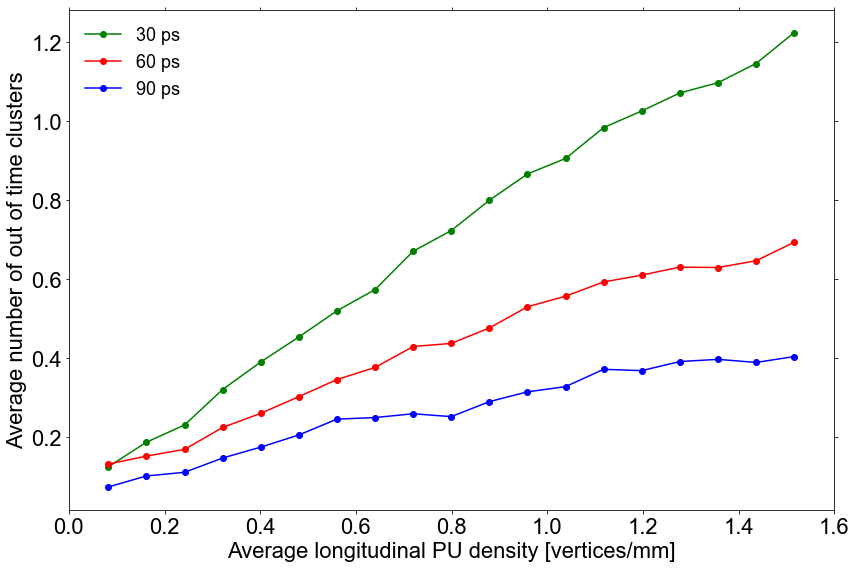

In [342]:
plt.plot(zAPU_truth_bin_edges[1:]-np.diff(zAPU_truth_bin_edges), link_zAPU_vtx_t30_info['cluster_avg_n_PUvxts'], 'go-', label='30 ps')
plt.plot(zAPU_truth_bin_edges[1:]-np.diff(zAPU_truth_bin_edges), link_zAPU_vtx_t60_info['cluster_avg_n_PUvxts'], 'ro-', label='60 ps')
plt.plot(zAPU_truth_bin_edges[1:]-np.diff(zAPU_truth_bin_edges), link_zAPU_vtx_t90_info['cluster_avg_n_PUvxts'], 'bo-', label='90 ps')

# plt.plot(zAPU_truth_bin_edges[1:]-np.diff(zAPU_truth_bin_edges), avg_n_miss_vtxs, 'ko-')
# plt.plot(zAPU_truth_bin_edges[1:]-np.diff(zAPU_truth_bin_edges), avg_n_miss_vtxs_weight_cut, 'ko--')

# plt.plot(zLPU_truth_bin_edges, avg_n_miss_vtxs_local, 'yo-')
# plt.plot(zLPU_truth_bin_edges, avg_n_miss_vtxs_weight_cut_local, 'yo--')

# plt.plot(zLPU_truth_bin_edges, link_zLPU_vtx_t60_info['cluster_avg_n_PUvxts'], 'ro-', label='Basic truthHS-reco link 60 ps')
# plt.plot(zLPU_truth_bin_edges, link_zLPU_vtx_t90_info['cluster_avg_n_PUvxts'], 'bo-', label='Basic truthHS-reco link 90 ps')
# plt.plot(zLPU_truth_bin_edges, link_zLPU_vtx_t30_info_req_cleanHS['cluster_avg_n_PUvxts'], 'ro-', label='Clean truthHS-recoHS link')
plt.ylabel('Average number of out of time clusters')
plt.xlabel('Average longitudinal PU density [vertices/mm]')
plt.xlim(0, 1.6)
# plt.ylim(0, 5)
plt.legend(frameon=False)
plt.tight_layout()
# plt.savefig('figs/out_of_time_clusters_v1.pdf')


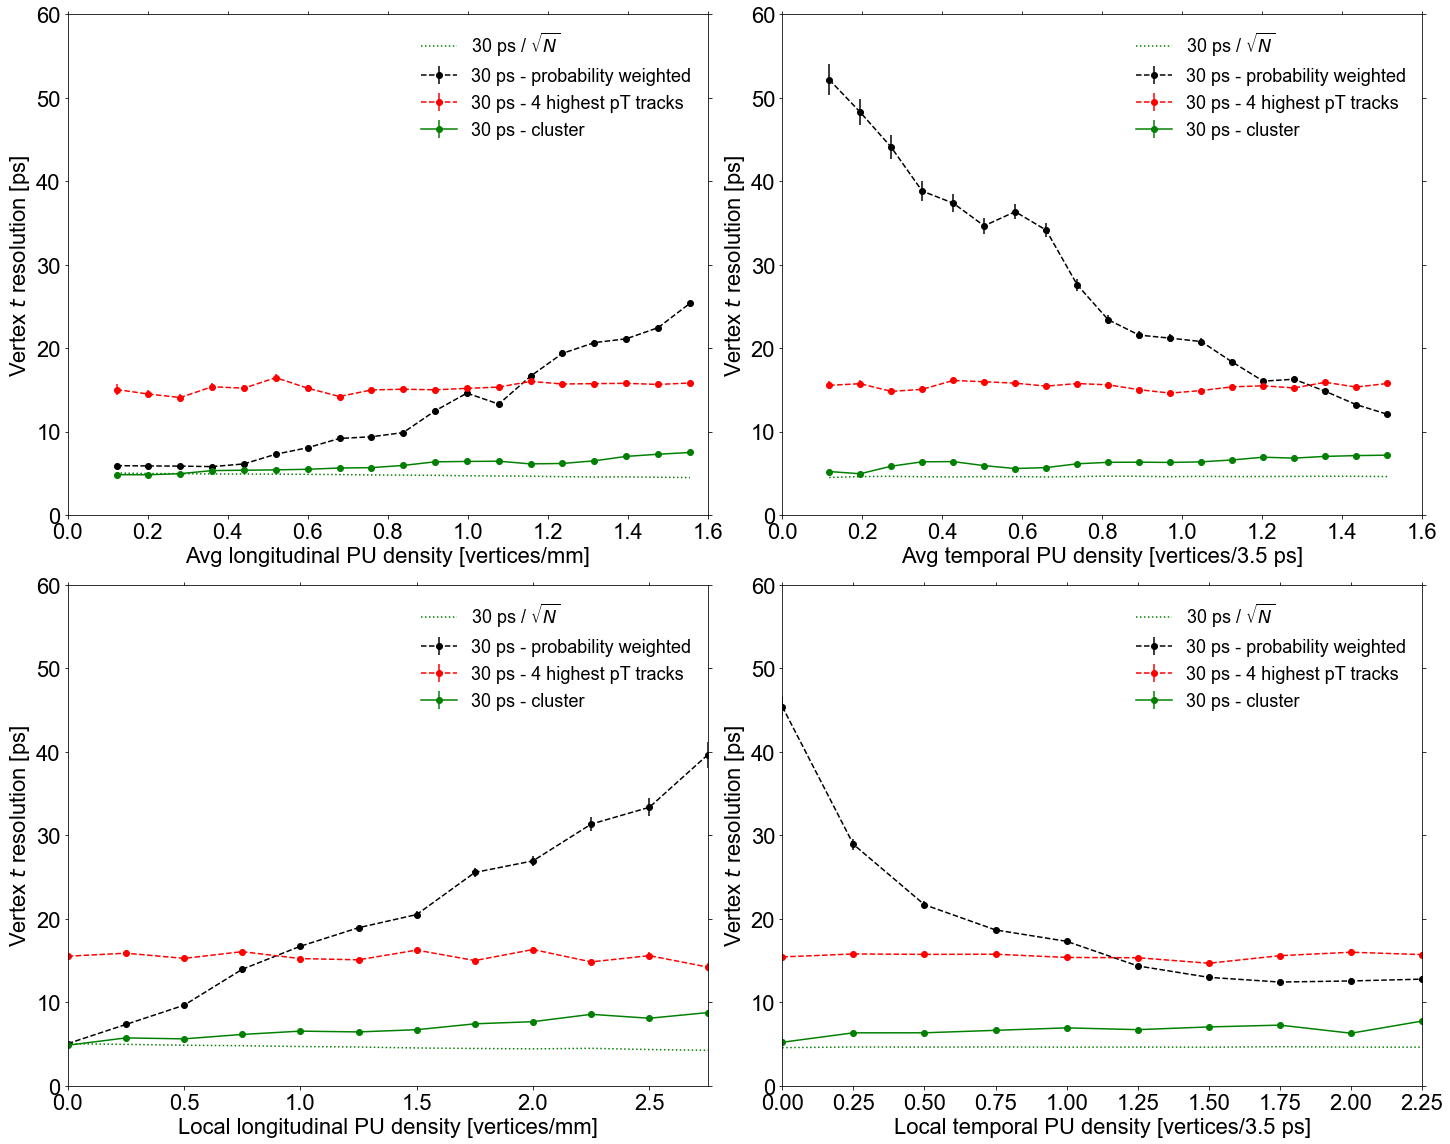

In [346]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(20, 16)

axes = (ax1, ax2, ax3, ax4)
all_bin_edges = (zAPU_truth_bin_edges[1:] - np.diff(zAPU_truth_bin_edges)/2, tAPU_truth_bin_edges[1:] - np.diff(tAPU_truth_bin_edges)/2, zLPU_truth_bin_edges, tLPU_truth_bin_edges)
all_link_vtx_info30 = (link_zAPU_vtx_t30_info, link_tAPU_vtx_t30_info, link_zLPU_vtx_t30_info, link_tLPU_vtx_t30_info)
all_link_vtx_info60 = (link_zAPU_vtx_t60_info, link_tAPU_vtx_t60_info, link_zLPU_vtx_t60_info, link_tLPU_vtx_t60_info)
all_link_vtx_info90 = (link_zAPU_vtx_t90_info, link_tAPU_vtx_t90_info, link_zLPU_vtx_t90_info, link_tLPU_vtx_t90_info)
# all_link_vtx_info180 = (link_zAPU_vtx_t180_info, link_tAPU_vtx_t180_info, link_zLPU_vtx_t180_info, link_tLPU_vtx_t180_info)
# all_link_vtx_info360 = (link_zAPU_vtx_t360_info, link_tAPU_vtx_t360_info, link_zLPU_vtx_t360_info, link_tLPU_vtx_t360_info)

# for ax, bin_edges, link_vtx_info30, link_vtx_info90, link_vtx_info180, link_vtx_info360 \
#             in zip(axes, all_bin_edges, all_link_vtx_info30, all_link_vtx_info90, all_link_vtx_info180, all_link_vtx_info360):
for ax, bin_edges, link_vtx_info30, link_vtx_info60, link_vtx_info90 \
            in zip(axes, all_bin_edges, all_link_vtx_info30, all_link_vtx_info60, all_link_vtx_info90):
    
                    
    ax.errorbar(bin_edges, 1e3*np.abs(link_vtx_info30['vtx_weighted_t_gaussian_std']),\
                    1e3*np.array(link_vtx_info30['vtx_weighted_t_gaussian_std_std']), fmt='ko--', label='30 ps - probability weighted')
                    
    # ax.errorbar(bin_edges, 1e3*np.abs(link_vtx_info60['vtx_weighted_t_gaussian_std']),\
    #                 1e3*np.array(link_vtx_info60['vtx_weighted_t_gaussian_std_std']), fmt='ro--', label='60 ps - probability weighted', alpha=0.5)
                    
    # ax.errorbar(bin_edges, 1e3*np.abs(link_vtx_info90['vtx_weighted_t_gaussian_std']),\
    #                 1e3*np.array(link_vtx_info90['vtx_weighted_t_gaussian_std_std']), fmt='bo--', label='90 ps - probability weighted', alpha=0.5)

    ax.errorbar(bin_edges, 1e3*np.abs(link_vtx_info30['vtx_4highest_pT_t_gaussian_std']),\
                    1e3*np.array(link_vtx_info30['vtx_4highest_pT_t_gaussian_std_std']), fmt='ro--', label='30 ps - 4 highest pT tracks')
    

    ax.errorbar(bin_edges, 1e3*np.abs(link_vtx_info30['cluster_vtx_t_gaussian_std']),\
                    1e3*np.array(link_vtx_info30['cluster_vtx_t_gaussian_std_std']), fmt='go-', label='30 ps - cluster')

    # ax.errorbar(bin_edges, 1e3*np.abs(link_vtx_info60['cluster_vtx_t_gaussian_std']),\
    #                 1e3*np.array(link_vtx_info60['cluster_vtx_t_gaussian_std_std']), fmt='ro-', label='60 ps - cluster')

    # ax.errorbar(bin_edges, 1e3*np.abs(link_vtx_info90['cluster_vtx_t_gaussian_std']),\
    #                 1e3*np.array(link_vtx_info90['cluster_vtx_t_gaussian_std_std']), fmt='bo-', label='90 ps - cluster')

    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info90['vtx_weighted_t_rms']),\
    #                 1e3*np.array(link_vtx_info90['vtx_weighted_t_rms_std']), fmt='ko-', label='90 ps - prob. weighted')

    ax.plot(bin_edges, 30/np.sqrt(link_vtx_info30['avg_n_tracks']), 'g:', label='30 ps / $\\sqrt{N}$')
    # ax.plot(bin_edges, 60/np.sqrt(link_vtx_info60['avg_n_tracks']), 'r:', label='60 ps / $\\sqrt{N}$')
    # ax.plot(bin_edges, 90/np.sqrt(link_vtx_info90['avg_n_tracks']), 'b:', label='90 ps / $\\sqrt{N}$')

    # ax.hlines(12, 0, 100)
    ax.set_ylim(0, 60)
    # ax.set_ylabel('Width of reco $t$ estimator - truth $t$ [ps]')
    ax.set_ylabel('Vertex $t$ resolution [ps]')
    ax.legend(frameon=False)

ax1.set_xlim(0, 1.6)
ax1.set_xlabel('Avg longitudinal PU density [vertices/mm]')
ax2.set_xlim(0, 1.6)
ax2.set_xlabel('Avg temporal PU density [vertices/3.5 ps]')
ax3.set_xlim(0, 2.75)
ax3.set_xlabel('Local longitudinal PU density [vertices/mm]')
ax4.set_xlim(0, 2.25)
ax4.set_xlabel('Local temporal PU density [vertices/3.5 ps]')

fig.tight_layout()
# fig.savefig('figs/t_res_30_weighted_4highest.pdf')

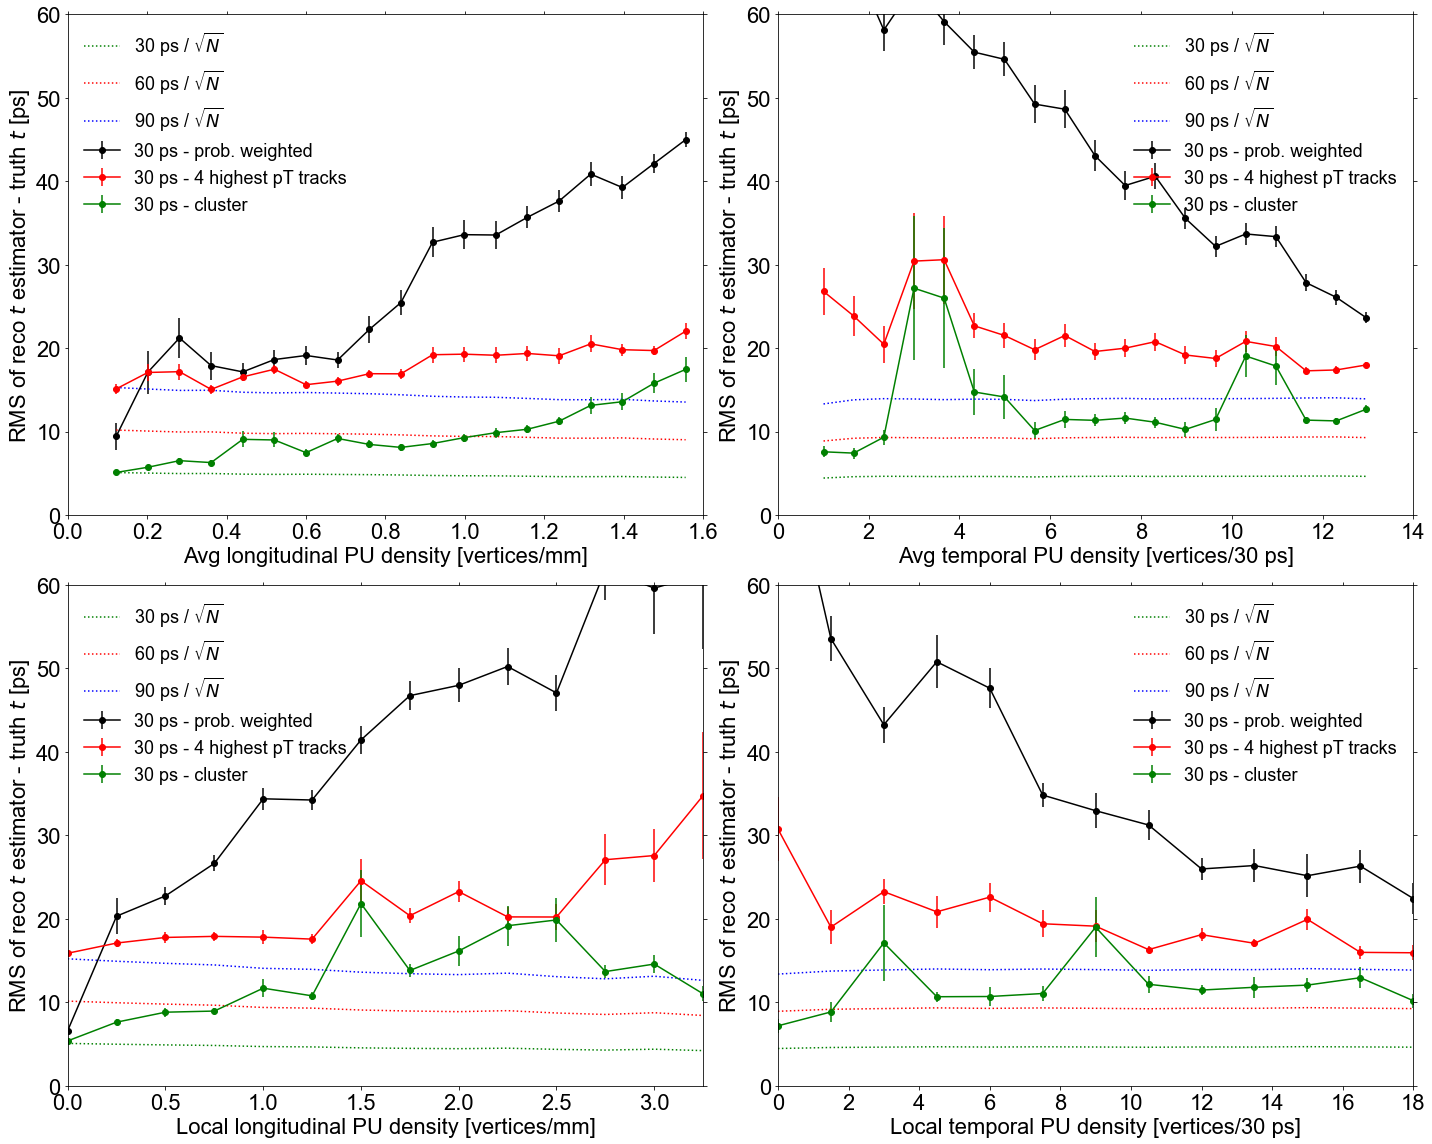

In [181]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(20, 16)

axes = (ax1, ax2, ax3, ax4)
all_bin_edges = (zAPU_truth_bin_edges[1:] - np.diff(zAPU_truth_bin_edges)/2, tAPU_truth_bin_edges[1:] - np.diff(tAPU_truth_bin_edges)/2, zLPU_truth_bin_edges, tLPU_truth_bin_edges)
all_link_vtx_info30 = (link_zAPU_vtx_t30_info, link_tAPU_vtx_t30_info, link_zLPU_vtx_t30_info, link_tLPU_vtx_t30_info)
all_link_vtx_info60 = (link_zAPU_vtx_t60_info, link_tAPU_vtx_t60_info, link_zLPU_vtx_t60_info, link_tLPU_vtx_t60_info)
all_link_vtx_info90 = (link_zAPU_vtx_t90_info, link_tAPU_vtx_t90_info, link_zLPU_vtx_t90_info, link_tLPU_vtx_t90_info)
# all_link_vtx_info180 = (link_zAPU_vtx_t180_info, link_tAPU_vtx_t180_info, link_zLPU_vtx_t180_info, link_tLPU_vtx_t180_info)
# all_link_vtx_info360 = (link_zAPU_vtx_t360_info, link_tAPU_vtx_t360_info, link_zLPU_vtx_t360_info, link_tLPU_vtx_t360_info)

# for ax, bin_edges, link_vtx_info30, link_vtx_info90, link_vtx_info180, link_vtx_info360 \
#             in zip(axes, all_bin_edges, all_link_vtx_info30, all_link_vtx_info90, all_link_vtx_info180, all_link_vtx_info360):
for ax, bin_edges, link_vtx_info30, link_vtx_info60, link_vtx_info90 \
            in zip(axes, all_bin_edges, all_link_vtx_info30, all_link_vtx_info60, all_link_vtx_info90):
    
    ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info30['vtx_weighted_t_rms']),\
                    1e3*np.array(link_vtx_info30['vtx_weighted_t_rms_std']), fmt='ko-', label='30 ps - prob. weighted')
    

    ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info30['vtx_4highest_pT_t_rms']),\
                    1e3*np.array(link_vtx_info30['vtx_4highest_pT_t_rms_std']), fmt='ro-', label='30 ps - 4 highest pT tracks')
    
    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info30['vtx_weight_cut_t_rms']),\
    #                 1e3*np.array(link_vtx_info30['vtx_weight_cut_t_rms_std']), fmt='bo-', label='30 ps - 0.9 cut')
                    


    ax.errorbar(bin_edges, 1e3*np.abs(link_vtx_info30['cluster_vtx_t_rms']),\
                    1e3*np.array(link_vtx_info30['cluster_vtx_t_rms_std']), fmt='go-', label='30 ps - cluster')

    ax.plot(bin_edges, 30/np.sqrt(link_vtx_info30['avg_n_tracks']), 'g:', label='30 ps / $\\sqrt{N}$')
    ax.plot(bin_edges, 60/np.sqrt(link_vtx_info60['avg_n_tracks']), 'r:', label='60 ps / $\\sqrt{N}$')
    ax.plot(bin_edges, 90/np.sqrt(link_vtx_info90['avg_n_tracks']), 'b:', label='90 ps / $\\sqrt{N}$')

    # ax.hlines(12, 0, 100)
    ax.set_ylim(0, 60)
    ax.set_ylabel('RMS of reco $t$ estimator - truth $t$ [ps]')
    ax.legend(frameon=False)

ax1.set_xlim(0, 1.6)
ax1.set_xlabel('Avg longitudinal PU density [vertices/mm]')
ax2.set_xlim(0, 14)
ax2.set_xlabel('Avg temporal PU density [vertices/30 ps]')
ax3.set_xlim(0, 3.25)
ax3.set_xlabel('Local longitudinal PU density [vertices/mm]')
ax4.set_xlim(0, 18)
ax4.set_xlabel('Local temporal PU density [vertices/30 ps]')

fig.tight_layout()
# fig.savefig('t_res_vs_PU_cluster_30_60_90.pdf')

Text(0.5, 0, 'Local temporal PU density [vertices/300 ps]')

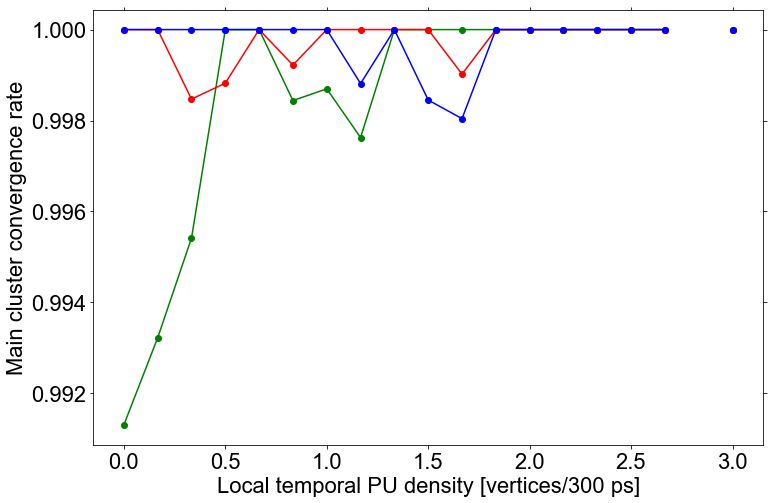

In [285]:
plt.plot(tLPU_truth_bin_edges, link_tLPU_vtx_t30_info['cluster_efficiency'], 'go-')
plt.plot(tLPU_truth_bin_edges, link_tLPU_vtx_t60_info['cluster_efficiency'], 'ro-')
plt.plot(tLPU_truth_bin_edges, link_tLPU_vtx_t90_info['cluster_efficiency'], 'bo-')
plt.ylabel('Main cluster convergence rate')
plt.xlabel('Local temporal PU density [vertices/300 ps]')

In [51]:
1e3*np.abs(link_zLPU_vtx_t30_info['vtx_weighted_t_gaussian_std']), 1e3*np.abs(link_zLPU_vtx_t30_info['cluster_vtx_t_gaussian_std_std'])

(array([ 5.25436717,  7.26670011,  9.97210104, 14.1466462 , 18.26557993,
        18.56946246, 21.68918906, 22.75451745, 28.79109192, 31.53527606,
        30.36599533, 42.85516859, 33.40942662, 39.25052388, 22.79751997,
        38.1664749 ,         nan, 15.40012255]),
 array([0.14949068, 0.15201869, 0.11329776, 0.12318916, 0.13587592,
        0.11331347, 0.1334436 , 0.15122293, 0.19456416, 0.25965126,
        0.30372009, 0.37773173, 0.78269078,        inf, 1.13355746,
        1.7172885 ,        nan,        nan]))

5.024219156648879


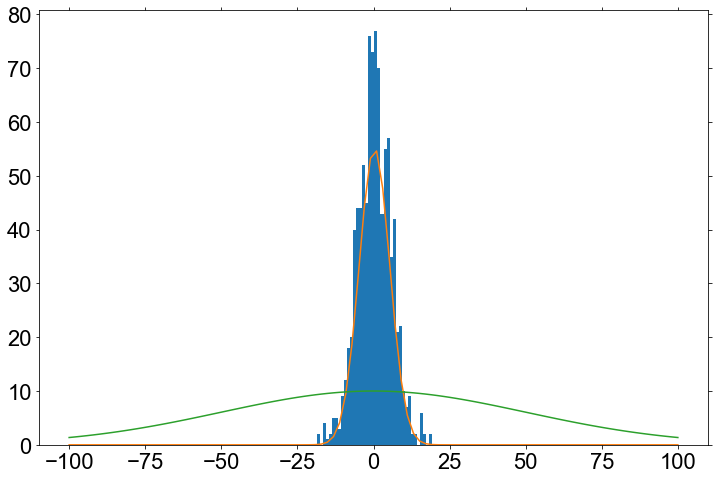

In [106]:
bin_width = 10e-3
delta_x = link_zLPU_vtx_t30_info['vtx_weighted_delta_t'][0]
delta_x = np.array(delta_x)[np.abs(delta_x) < 3*np.std(delta_x, ddof=1)]

n_events = len(delta_x)
# bins = np.arange(np.min(delta_x)-bin_width, np.max(delta_x)+bin_width, bin_width)
bins = np.ceil(2*n_events**0.33)
bins = int(bins)
popt, pcov = gaussian_fit(delta_x, sigma_0=30e-3, bin_width=10e-3)

_ = plt.hist(1e3*np.array(delta_x), bins=2*bins)

xs = np.linspace(-0.1, 0.1, 100)
_ = plt.plot(1e3*xs, gaussian_no_bkg(xs, *popt))
_ = plt.plot(1e3*xs, gaussian_no_bkg(xs, 10, 0, 50e-3))
print(1e3*popt[2])

6.667240958545849 0.13561084175063387


(-0.1, 0.1)

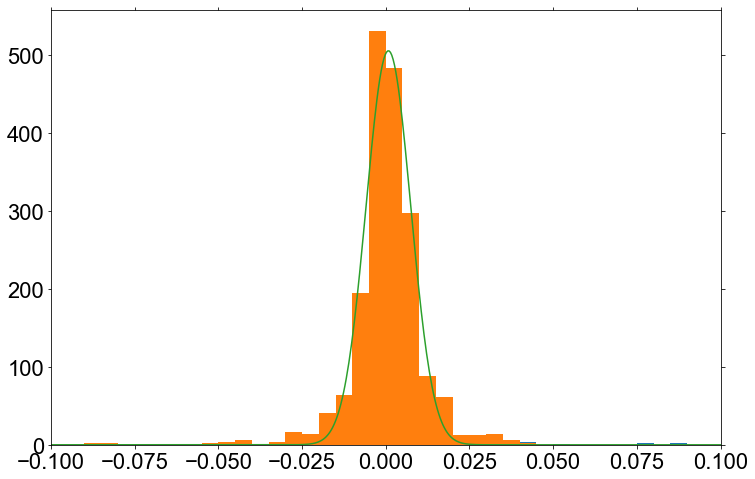

In [193]:

bins = np.arange(-0.3, 0.5, 5e-3) 
_ = plt.hist(link_zLPU_vtx_t30_info['cluster_vtx_delta_t'][6], bins=bins)
_ = plt.hist(np.array(link_zLPU_vtx_t30_info['cluster_vtx_delta_t'][6])[link_zLPU_vtx_t30_info['cluster_vtx_delta_t'][6] < 2*np.std(link_zLPU_vtx_t30_info['cluster_vtx_delta_t'][6])], bins=bins)

popt, pcov = gaussian_fit(link_zLPU_vtx_t30_info['cluster_vtx_delta_t'][6], 30e-3, 5e-3)
print(1e3*popt[2], 1e3*pcov[2, 2]**0.5)
xs = np.linspace(-0.2, 0.2, 1000)
plt.plot(xs, gaussian_no_bkg(xs, *popt))
plt.xlim(-0.1, 0.1)
# plt.yscale('log')

In [ ]:
### do time clustering on reco tracks
## group tracks together if delta t < track sigma_t
## get number of PU vtx contaminations from number of clusters
# new t estimator from highest sumpt2 cluster 

In [17]:
pu_bin_idx = 0
pu_bin_delta_ts = link_tLPU_vtx_t30_info['vtx_weighted_delta_t'][pu_bin_idx]
delta_t_sigma = np.std(pu_bin_delta_ts)
print("number of events in bin", len(pu_bin_delta_ts))

event_in_bin_idx = np.argmin(np.abs(link_tLPU_vtx_t30_info['vtx_weighted_delta_t'][pu_bin_idx] - delta_t_sigma))

delta_t = link_tLPU_vtx_t30_info['vtx_weighted_delta_t'][pu_bin_idx][event_in_bin_idx]
event_idx = events_in_zLPU_bins[pu_bin_idx][event_in_bin_idx][0]
reco_idx = truthHS_to_reco_delta_z_cut_link_idx[event_idx]
reco_idx_delta_z_cut = truthHS_to_reco_delta_z_cut_link_idx[event_idx]
reco_z = reco_vertex_z[event_idx][reco_idx]
delta_z = reco_vertex_z[event_idx][reco_idx] - truth_vertex_z[event_idx][0]

print('pu bin', pu_bin_idx)
print('bin event idx', event_in_bin_idx)
print('abs event', event_idx)
print('bin sigma (ps)', 1e3*delta_t_sigma)
print('delta_t (ps)', delta_t*1e3, '\nAthena reco_z (mm)', reco_z, '\nDelta z (µm)', 1e3*delta_z, '\nreco_idx', reco_idx, '\nreco_idx_delta_z_cut', reco_idx_delta_z_cut)
print('tLPU', truth_localtPU[event_idx])
print('zLPU', truth_localzPU[event_idx])
print(abs_event_to_specific_ntuple_event(event_idx, files))

number of events in bin 278
pu bin 0
bin event idx 264
abs event 5287
bin sigma (ps) 81.3395231962204
delta_t (ps) 81.44514262676239 
Athena reco_z (mm) -126.29954 
Delta z (µm) 0.518798828125 
reco_idx 0 
reco_idx_delta_z_cut 0
tLPU 1.5
zLPU 0.0
('../ntuples/ttbar/OutDir_8/hist-Rel21sample.root', 'EventTree;3', 160)


Text(0.5, 0, 'Reco vtx track t [ps]')

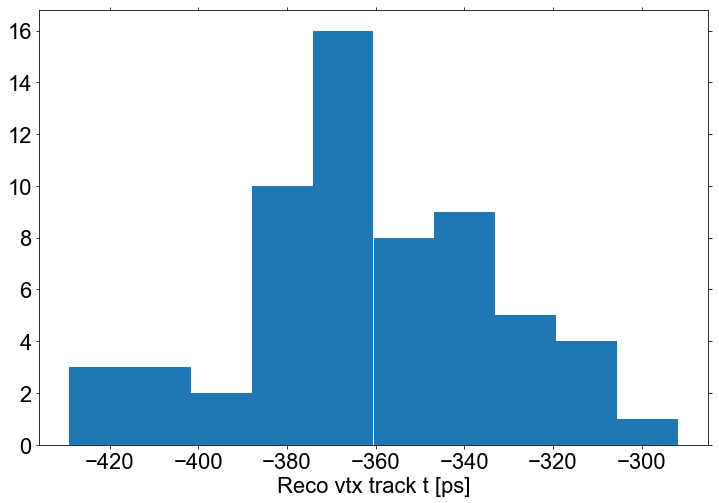

In [18]:
reco_track_ts = track_t30[event_idx][reco_vertex_track_idxs[event_idx][reco_idx]]
reco_track_ts = reco_track_ts[np.logical_and(reco_track_ts != -1e3, reco_track_ts != -1e6)]
truth_t = track_t[event_idx][truth_vertex_track_idxs[event_idx][0][0]]


_ = plt.hist(1e3*np.array(reco_track_ts))

plt.xlabel('Reco vtx track t [ps]')

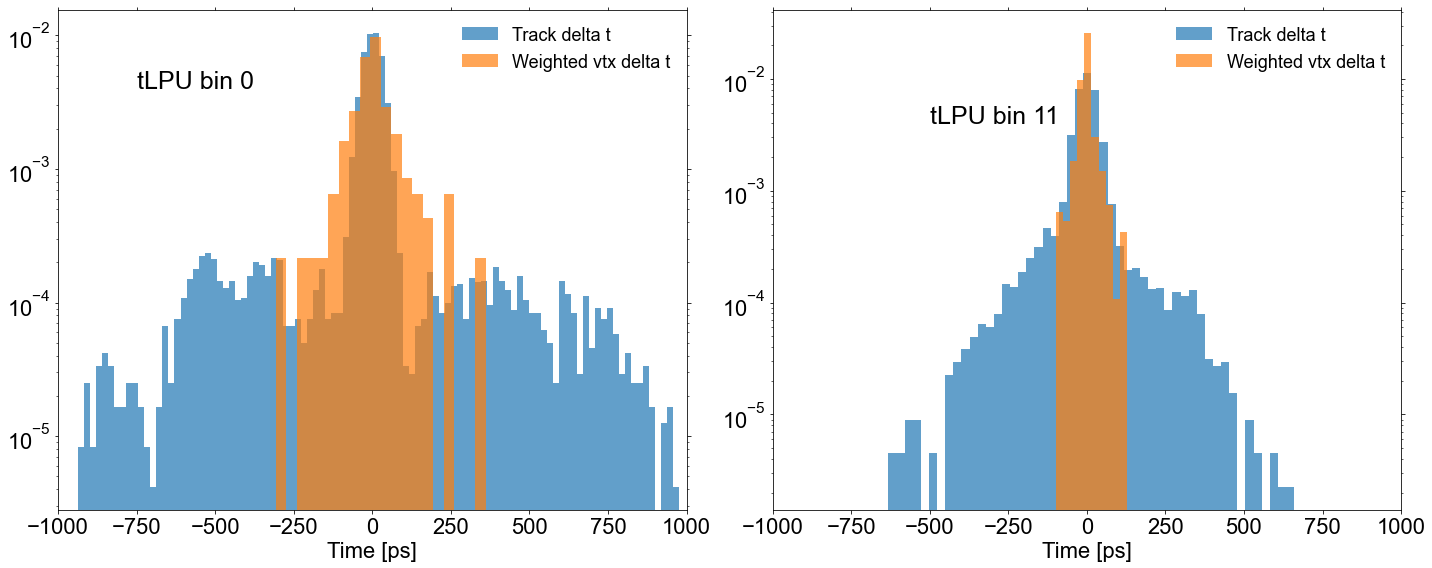

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 8)

bin_idx1 = 0
bin_idx2 = 11

ax1.hist(1e3*np.array(link_tLPU_vtx_t30_info['track_delta_t'][bin_idx1]), bins=100, density=True, alpha=0.7, label='Track delta t')
ax1.hist(1e3*np.array(link_tLPU_vtx_t30_info['vtx_weighted_delta_t'][bin_idx1]), bins=20, density=True, alpha=0.7, label='Weighted vtx delta t')
ax1.text(-750, 4e-3, 'tLPU bin {}'.format(bin_idx1), fontsize=25)

ax2.hist(1e3*np.array(link_tLPU_vtx_t30_info['track_delta_t'][bin_idx2]), bins=50, density=True, alpha=0.7, label='Track delta t')
ax2.hist(1e3*np.array(link_tLPU_vtx_t30_info['vtx_weighted_delta_t'][bin_idx2]), bins=10, density=True, alpha=0.7, label='Weighted vtx delta t')
ax2.text(-500, 4e-3, 'tLPU bin {}'.format(bin_idx2), fontsize=25)

ax1.set_xlabel('Time [ps]')
ax1.set_yscale('log')
ax1.set_xlim(-1e3, 1e3)
ax1.legend(frameon=False)

ax2.set_xlabel('Time [ps]')
ax2.set_yscale('log')
ax2.set_xlim(-1e3, 1e3)
ax2.legend(frameon=False)

plt.tight_layout()
# print(np.std(np.concatenate(link_zLPU_vtx_z_info['track_sigma_cut_delta_z'][idx]), ddof=1)/30**0.5, np.std(link_zLPU_vtx_z_info['vtx_weighted_delta_z'][idx], ddof=1))

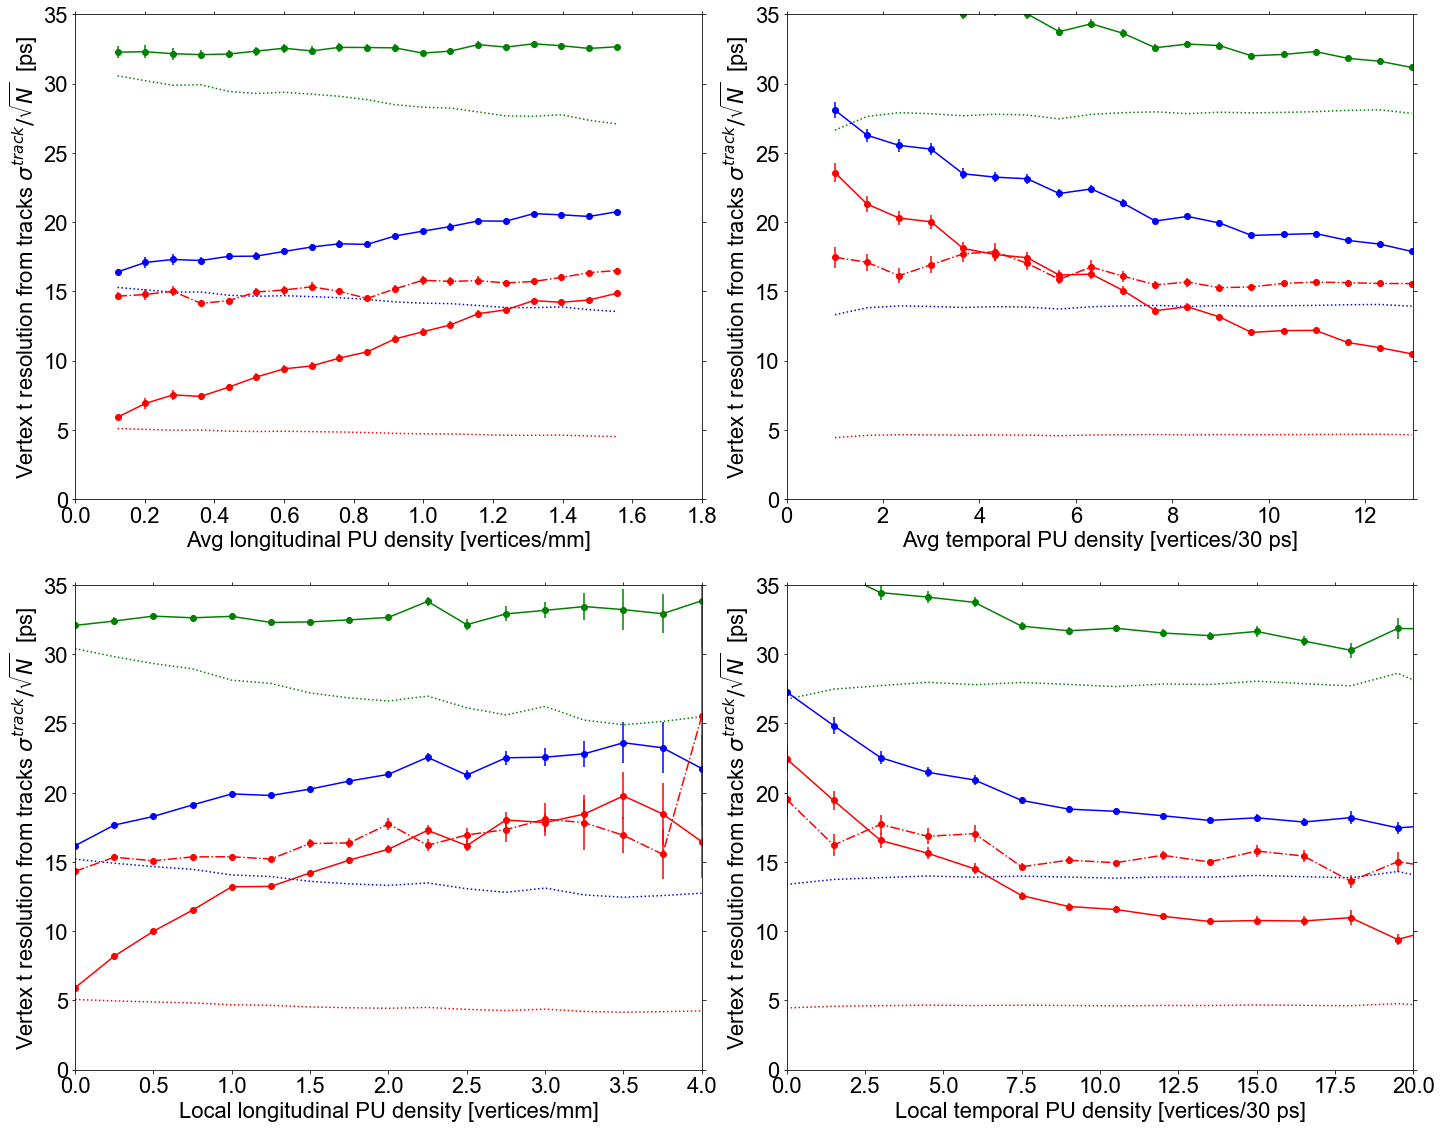

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(20, 16)

axes = (ax1, ax2, ax3, ax4)
all_bin_edges = (zAPU_truth_bin_edges[1:] - np.diff(zAPU_truth_bin_edges)/2, tAPU_truth_bin_edges[1:] - np.diff(tAPU_truth_bin_edges)/2, zLPU_truth_bin_edges, tLPU_truth_bin_edges)
all_link_vtx_info30 = (link_zAPU_vtx_t30_info, link_tAPU_vtx_t30_info, link_zLPU_vtx_t30_info, link_tLPU_vtx_t30_info)
all_link_vtx_info90 = (link_zAPU_vtx_t90_info, link_tAPU_vtx_t90_info, link_zLPU_vtx_t90_info, link_tLPU_vtx_t90_info)
all_link_vtx_info180 = (link_zAPU_vtx_t180_info, link_tAPU_vtx_t180_info, link_zLPU_vtx_t180_info, link_tLPU_vtx_t180_info)

for ax, bin_edges, link_vtx_info30, link_vtx_info90, link_vtx_info180 \
            in zip(axes, all_bin_edges, all_link_vtx_info30, all_link_vtx_info90, all_link_vtx_info180):
    ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info30['track_vtx_t_res']), \
                1e3*np.array(link_vtx_info30['track_vtx_t_res_std']), fmt='ro-', label='30 ps - Track vtx t estimate')
    ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info90['track_vtx_t_res']), \
                1e3*np.array(link_vtx_info90['track_vtx_t_res_std']), fmt='bo-', label='90 ps - Track vtx t estimate')
    ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info180['track_vtx_t_res']), \
                1e3*np.array(link_vtx_info180['track_vtx_t_res_std']), fmt='go-', label='180 ps - Track vtx t estimate')

    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info30['track_vtx_t_res_sigma_cut']),\
    #                 1e3*np.array(link_vtx_info30['track_vtx_t_res_std_sigma_cut']), fmt='ro--', label='30 ps - Sigma cut on track t distribution')
    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info90['track_vtx_t_res_sigma_cut']),\
    #                 1e3*np.array(link_vtx_info90['track_vtx_t_res_std_sigma_cut']), fmt='bo--', label='90 ps - Sigma cut on track t distribution')
    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info180['track_vtx_t_res_sigma_cut']),\
    #                 1e3*np.array(link_vtx_info180['track_vtx_t_res_std_sigma_cut']), fmt='go--', label='180 ps - Sigma cut on track t distribution')
    
    ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info30['track_vtx_4highest_pT_t_res']),\
                    1e3*np.array(link_vtx_info30['track_vtx_4highest_pT_t_res_std']), fmt='ro-.', label='30 ps - Sigma cut on track t distribution')
    ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info90['track_vtx_4highest_pT_t_res']),\
                    1e3*np.array(link_vtx_info90['track_vtx_4highest_pT_t_res_std']), fmt='bo-.', label='90 ps - Sigma cut on track t distribution')
    ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info180['track_vtx_4highest_pT_t_res']),\
                    1e3*np.array(link_vtx_info180['track_vtx_4highest_pT_t_res_std']), fmt='go-.', label='180 ps - Sigma cut on track t distribution')

    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info30['track_vtx_t_res_weight_cut']),\
    #                 1e3*np.array(link_vtx_info30['track_vtx_t_res_std_weight_cut']), fmt='ro-', label='30 ps - Weight cut on tracks')
    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info90['track_vtx_t_res_weight_cut']),\
    #                 1e3*np.array(link_vtx_info90['track_vtx_t_res_std_weight_cut']), fmt='bo-', label='90 ps - Weight cut on tracks')
    # ax.errorbar(bin_edges, 1e3*np.array(link_vtx_info180['track_vtx_t_res_weight_cut']),\
    #                 1e3*np.array(link_vtx_info180['track_vtx_t_res_std_weight_cut']), fmt='go-', label='180 ps - Weight cut on tracks')


    ax.plot(bin_edges, 30/np.sqrt(link_vtx_info30['avg_n_tracks']), 'r:', label='30 ps / $\\sqrt{N}$')
    ax.plot(bin_edges, 90/np.sqrt(link_vtx_info90['avg_n_tracks']), 'b:', label='90 ps / $\\sqrt{N}$')
    ax.plot(bin_edges, 180/np.sqrt(link_vtx_info180['avg_n_tracks']), 'g:', label='180 ps / $\\sqrt{N}$')

    # ax.hlines(12, 0, 50)
    ax.set_ylim(0, 35)
    ax.set_ylabel('Vertex t resolution from tracks $\\sigma^{track}/\\sqrt{N}$  [ps]')
    # ax.legend(frameon=False)

ax1.set_xlim(0, 1.8)
ax1.set_xlabel('Avg longitudinal PU density [vertices/mm]')
ax2.set_xlim(0, 13)
ax2.set_xlabel('Avg temporal PU density [vertices/30 ps]')
ax3.set_xlim(0, 4)
ax3.set_xlabel('Local longitudinal PU density [vertices/mm]')
ax4.set_xlim(0, 20)
ax4.set_xlabel('Local temporal PU density [vertices/30 ps]')

fig.tight_layout()

Text(0, 0.5, 'Track pT')

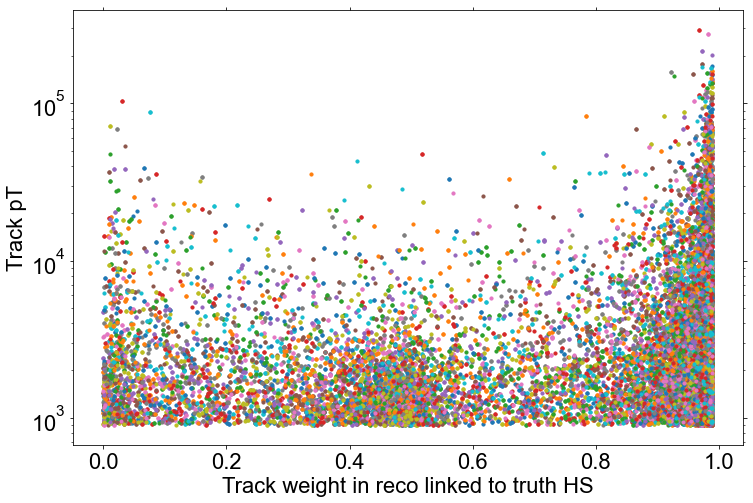

In [82]:
## Track pT vs track weight
for event_idx in range(0, 1000):
    reco_idx = truthHS_to_reco_link_idx[event_idx]
    event_track_pT = track_pT[event_idx][reco_vertex_track_idxs[event_idx][reco_idx]]
    event_track_weight = reco_vertex_track_weights[event_idx][reco_idx]
    plt.scatter(event_track_weight, event_track_pT, s=10)

plt.yscale('log')
plt.xlabel('Track weight in reco linked to truth HS')
plt.ylabel('Track pT')

In [ ]:
## pT vs weight
## vertex t estimation from 4 high pT tracks with/without weight > 0.9
## vertex t estimation from 4 highest weight

In [21]:
def old_vtx_time_info(events_in_PU_bins, truth_vtx_idx_in_PU_bins, all_truth_vtx_t, reco_vtx_idx_in_PU_bins, all_reco_track_idxs, all_reco_track_weights, all_track_t, sigma_cut, weight_cut):
    track_delta_t = []
    track_delta_t_rms = []
    
    track_weight_cut_delta_t = []
    track_weight_cut_delta_t_rms = []
    
    track_vtx_t_res = []
    track_vtx_t_res_weight_cut = []
    track_vtx_t_res_sigma_cut = []
    
    vtx_delta_t = []
    vtx_weighted_delta_t = []
    vtx_weight_cut_delta_t = []
    
    vtx_t_res = []
    vtx_weighted_t_res = []
    vtx_weight_cut_t_res = []
    vtx_weight_cut_weighted_t_res = []
    vtx_sigma_cut_weighted_t_res = []

    avg_n_tracks = []
    avg_n_tracks_weight_cut = []
    avg_n_tracks_sigma_cut = []

    for event_idxs, truth_vtx_idxs, reco_vtx_idxs in zip(events_in_PU_bins, truth_vtx_idx_in_PU_bins, reco_vtx_idx_in_PU_bins):
        bin_track_delta_t = np.array([])
        bin_track_delta_t_rms = []
        
        bin_vtx_delta_t = []
        bin_vtx_weighted_delta_t = []
        
        bin_track_weight_cut_delta_t = np.array([])
        bin_track_weight_cut_delta_t_rms = []
        
        bin_vtx_weight_cut_delta_t = []
        bin_vtx_weight_cut_weighted_delta_t = []
        
        bin_reco_n_tracks = []
        bin_reco_n_tracks_weight_cut = []
        for idx, truth_idx, reco_idx in zip(event_idxs, truth_vtx_idxs, reco_vtx_idxs):
            idx = idx[0]
            reco_track_t = all_track_t[idx][all_reco_track_idxs[idx][reco_idx]]
            reco_track_t_clean_idx = np.logical_and(reco_track_t != -1e3, reco_track_t != -1e6)
            reco_track_t = reco_track_t[np.logical_and(reco_track_t != -1e3, reco_track_t != -1e6)]
            reco_track_weights = all_reco_track_weights[idx][reco_idx][reco_track_t_clean_idx]
            bin_reco_n_tracks.append(len(reco_track_t))
            
            truth_t = all_truth_vtx_t[idx][truth_idx]
            event_track_delta_t = reco_track_t - truth_t
            
            bin_track_delta_t = np.concatenate((bin_track_delta_t, event_track_delta_t))
            bin_track_delta_t_rms.append(np.sqrt(np.mean(event_track_delta_t**2)))
            
            reco_vtx_t = np.mean(reco_track_t)
            reco_vtx_weighted_t = np.average(reco_track_t, weights=reco_track_weights)
            
            bin_vtx_delta_t.append(reco_vtx_t - truth_t)
            bin_vtx_weighted_delta_t.append(reco_vtx_weighted_t - truth_t)
            
            # Weight cut
            weight_cut_idx = np.array(reco_track_weights) > weight_cut
            weight_cut_track_t = reco_track_t[weight_cut_idx]
            bin_reco_n_tracks_weight_cut.append(len(weight_cut_track_t))
            
            weight_cut_event_delta_t = weight_cut_track_t - truth_t
        
            bin_track_weight_cut_delta_t = np.concatenate((bin_track_weight_cut_delta_t, weight_cut_event_delta_t))
            bin_track_weight_cut_delta_t_rms.append(np.sqrt(np.mean(weight_cut_event_delta_t**2)))
            
            weight_cut_vtx_t = np.mean(weight_cut_track_t)
            weight_cut_vtx_weighted_t = np.average(weight_cut_track_t, weights = reco_track_weights[weight_cut_idx])
            
            bin_vtx_weight_cut_delta_t.append(weight_cut_vtx_t - truth_t)
            bin_vtx_weight_cut_weighted_delta_t.append(weight_cut_vtx_weighted_t - truth_t)
        
        avg_n_tracks.append(np.mean(bin_reco_n_tracks))
        avg_n_tracks_weight_cut.append(np.mean(bin_reco_n_tracks_weight_cut))
        
        track_delta_t.append(bin_track_delta_t)
        track_delta_t_rms.append(bin_track_delta_t_rms)
        track_weight_cut_delta_t.append(bin_track_weight_cut_delta_t)
        track_weight_cut_delta_t_rms.append(bin_track_weight_cut_delta_t_rms)
        track_vtx_t_res.append(np.mean(bin_track_delta_t_rms / np.sqrt(np.array(bin_reco_n_tracks))))
        track_vtx_t_res_weight_cut.append(np.mean(bin_track_weight_cut_delta_t_rms / np.sqrt(np.array(bin_reco_n_tracks_weight_cut))))
        
        
        vtx_delta_t.append(bin_vtx_delta_t)
        vtx_weighted_delta_t.append(bin_vtx_weighted_delta_t)
        vtx_weight_cut_delta_t.append(bin_vtx_weight_cut_delta_t)
        
        vtx_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_delta_t)**2)))
        vtx_weighted_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weighted_delta_t)**2)))
        vtx_weight_cut_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_delta_t)**2)))
        vtx_weight_cut_weighted_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_weighted_delta_t)**2)))
        
        bin_vtx_weighted_delta_t_sigma = np.std(bin_vtx_weighted_delta_t, ddof=1)
        bin_vtx_delta_t_sigma_cut_idxs = np.abs(bin_vtx_weighted_delta_t - np.mean(bin_vtx_weighted_delta_t)) < sigma_cut*bin_vtx_weighted_delta_t_sigma
        vtx_sigma_cut_weighted_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_weighted_delta_t)[bin_vtx_delta_t_sigma_cut_idxs]**2)))
        
    return  avg_n_tracks, \
            track_delta_t, \
            track_delta_t_rms, \
            track_weight_cut_delta_t, \
            track_weight_cut_delta_t_rms, \
            track_vtx_t_res, \
            track_vtx_t_res_weight_cut, \
            vtx_delta_t, \
            vtx_weight_cut_delta_t, \
            vtx_t_res, \
            vtx_weighted_t_res, \
            vtx_weight_cut_t_res, \
            vtx_weight_cut_weighted_t_res, \
            vtx_sigma_cut_weighted_t_res

def old_closest_truth_vtx_time_info(events_in_PU_bins, all_truth_vtx_z, all_truth_vtx_t, all_reco_track_idxs, all_reco_track_weights, all_reco_vtx_z, all_track_t, sigma_cut, weight_cut):
    reco_vtx_idx_in_PU_bins = [[0 for idx in event_idx] for event_idx in events_in_PU_bins]
    truth_vtx_idx_in_PU_bins = [[np.argmin(np.abs(truth_vertex_z[idx[0]] - reco_vertex_z[idx[0]][0])) for idx in event_idx] for event_idx in events_in_PU_bins]
    return old_vtx_time_info(events_in_PU_bins, truth_vtx_idx_in_PU_bins, all_truth_vtx_t, reco_vtx_idx_in_PU_bins, all_reco_track_idxs, all_reco_track_weights, all_track_t, sigma_cut, weight_cut)

def old_truth_to_reco_link_vtx_time_info(events_in_PU_bins, all_truthHS_to_reco_idx, all_truth_vtx_t, all_reco_track_idxs, all_reco_track_weights, all_track_t, sigma_cut, weight_cut):
    truth_vtx_idx_in_PU_bins = [[0 for idx in event_idx] for event_idx in events_in_PU_bins]
    reco_vtx_idx_in_PU_bins = [[all_truthHS_to_reco_idx[idx[0]] for idx in event_idx] for event_idx in events_in_PU_bins]
    
    return old_vtx_time_info(events_in_PU_bins, truth_vtx_idx_in_PU_bins, all_truth_vtx_t, reco_vtx_idx_in_PU_bins, all_reco_track_idxs, all_reco_track_weights, all_track_t, sigma_cut, weight_cut)
    

## TODO: write function to load root files into ram when needed instead of all at once 
    

        # bin_sigma = np.std(bin_closest_truth_delta_t)
        # bin_closest_truth_t30_diff_std_of_mean_sigma_cut = []
        # reco_n_tracks_events_cut = []
        # for idx in event_idxs:
        #     diff_t30_sigma_cut = diff_t30[np.abs(diff_t30 - np.mean(diff_t30)) < sigma_cut*bin_sigma]
        #     reco_n_tracks_events_cut.append(len(diff_t30_sigma_cut))
        #     bin_closest_truth_t30_diff_std_of_mean_sigma_cut.append(np.std(diff_t30_sigma_cut)/np.sqrt(len(diff_t30_sigma_cut)))
        # closest_truth_vtx_t30_res_sigma_cut.append(np.mean(bin_closest_truth_t30_diff_std_of_mean_sigma_cut))
        # avg_n_tracks30_sigma_cut.append(np.mean(reco_n_tracks_events_cut))

In [11]:
def closest_truth_vtx_time_info(events_in_PU_bins, all_truth_vtx_z, all_truth_vtx_t, all_reco_track_idxs, all_reco_track_weights, all_reco_vtx_z, all_track_t, sigma_cut, weight_cut):
    track_delta_t = []
    track_delta_t_rms = []
    
    track_weight_cut_delta_t = []
    track_weight_cut_delta_t_rms = []
    
    track_vtx_t_res = []
    track_vtx_t_res_weight_cut = []
    track_vtx_t_res_sigma_cuts = []
    
    vtx_delta_t = []
    vtx_weighted_delta_t = []
    vtx_weight_cut_delta_t = []
    
    vtx_t_res = []
    vtx_weighted_t_res = []
    vtx_weight_cut_t_res = []
    vtx_weight_cut_weighted_t_res = []
    vtx_sigma_cut_weighted_t_res = []

    avg_n_tracks = []
    avg_n_tracks_weight_cut = []
    avg_n_tracks_sigma_cut = []

    for event_idxs in events_in_PU_bins:
        bin_track_delta_t = np.array([])
        bin_track_delta_t_rms = []
        
        bin_vtx_delta_t = []
        bin_vtx_weighted_delta_t = []
        
        bin_track_weight_cut_delta_t = np.array([])
        bin_track_weight_cut_delta_t_rms = []
        
        bin_vtx_weight_cut_delta_t = []
        bin_vtx_weight_cut_weighted_delta_t = []
        
        bin_reco_n_tracks = []
        bin_reco_n_tracks_weight_cut = []
        for idx in event_idxs:
            idx = idx[0]
            #Use reco HS - ie. largest sumpT2 vtx
            reco_vtx_z = all_reco_vtx_z[idx][0]
            reco_track_t = all_track_t[idx][all_reco_track_idxs[idx][0]]
            reco_track_t_clean_idx = np.logical_and(reco_track_t != -1e3, reco_track_t != -1e6)
            reco_track_t = reco_track_t[np.logical_and(reco_track_t != -1e3, reco_track_t != -1e6)]
            reco_track_weights = all_reco_track_weights[idx][0][reco_track_t_clean_idx]
            bin_reco_n_tracks.append(len(reco_track_t))
            
            truth_t = all_truth_vtx_t[idx][np.argmin(np.abs(all_truth_vtx_z[idx] - reco_vtx_z))]
            
            event_track_delta_t = reco_track_t - truth_t
            
            bin_track_delta_t = np.concatenate((bin_track_delta_t, event_track_delta_t))
            bin_track_delta_t_rms.append(np.sqrt(np.mean(event_track_delta_t**2)))
            
            reco_vtx_t = np.mean(reco_track_t)
            reco_vtx_weighted_t = np.average(reco_track_t, weights=reco_track_weights)
            
            bin_vtx_delta_t.append(reco_vtx_t - truth_t)
            bin_vtx_weighted_delta_t.append(reco_vtx_weighted_t - truth_t)
            
            # Weight cut
            weight_cut_idx = np.array(reco_track_weights) > weight_cut
            weight_cut_track_t = reco_track_t[weight_cut_idx]
            bin_reco_n_tracks_weight_cut.append(len(weight_cut_track_t))
            
            weight_cut_event_delta_t = weight_cut_track_t - truth_t
        
            bin_track_weight_cut_delta_t = np.concatenate((bin_track_weight_cut_delta_t, weight_cut_event_delta_t))
            bin_track_weight_cut_delta_t_rms.append(np.sqrt(np.mean(weight_cut_event_delta_t**2)))
            
            weight_cut_vtx_t = np.mean(weight_cut_track_t)
            weight_cut_vtx_weighted_t = np.average(weight_cut_track_t, weights = reco_track_weights[weight_cut_idx])
            
            bin_vtx_weight_cut_delta_t.append(weight_cut_vtx_t - truth_t)
            bin_vtx_weight_cut_weighted_delta_t.append(weight_cut_vtx_weighted_t - truth_t)
        
        avg_n_tracks.append(np.mean(bin_reco_n_tracks))
        avg_n_tracks_weight_cut.append(np.mean(bin_reco_n_tracks_weight_cut))
        
        track_delta_t.append(bin_track_delta_t)
        track_delta_t_rms.append(bin_track_delta_t_rms)
        track_weight_cut_delta_t.append(bin_track_weight_cut_delta_t)
        track_weight_cut_delta_t_rms.append(bin_track_weight_cut_delta_t_rms)
        track_vtx_t_res.append(np.mean(bin_track_delta_t_rms / np.sqrt(np.array(bin_reco_n_tracks))))
        track_vtx_t_res_weight_cut.append(np.mean(bin_track_weight_cut_delta_t_rms / np.sqrt(np.array(bin_reco_n_tracks_weight_cut))))
        
        
        vtx_delta_t.append(bin_vtx_delta_t)
        vtx_weighted_delta_t.append(bin_vtx_weighted_delta_t)
        vtx_weight_cut_delta_t.append(bin_vtx_weight_cut_delta_t)
        
        vtx_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_delta_t)**2)))
        vtx_weighted_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weighted_delta_t)**2)))
        vtx_weight_cut_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_delta_t)**2)))
        vtx_weight_cut_weighted_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_weighted_delta_t)**2)))
        
        bin_vtx_weighted_delta_t_sigma = np.std(bin_vtx_weighted_delta_t, ddof=1)
        bin_vtx_delta_t_sigma_cut_idxs = np.abs(bin_vtx_weighted_delta_t - np.mean(bin_vtx_weighted_delta_t)) < sigma_cut*bin_vtx_weighted_delta_t_sigma
        vtx_sigma_cut_weighted_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_weighted_delta_t)[bin_vtx_delta_t_sigma_cut_idxs]**2)))
        
    return  track_delta_t, \
            track_delta_t_rms, \
            track_weight_cut_delta_t, \
            track_weight_cut_delta_t_rms, \
            track_vtx_t_res, \
            track_vtx_t_res_weight_cut, \
            vtx_delta_t, \
            vtx_weight_cut_delta_t, \
            vtx_t_res, \
            vtx_weighted_t_res, \
            vtx_weight_cut_t_res, \
            vtx_weight_cut_weighted_t_res, \
            vtx_sigma_cut_weighted_t_res
            
        # bin_sigma = np.std(bin_closest_truth_delta_t)
        # bin_closest_truth_t30_diff_std_of_mean_sigma_cut = []
        # reco_n_tracks_events_cut = []
        # for idx in event_idxs:
        #     diff_t30_sigma_cut = diff_t30[np.abs(diff_t30 - np.mean(diff_t30)) < sigma_cut*bin_sigma]
        #     reco_n_tracks_events_cut.append(len(diff_t30_sigma_cut))
        #     bin_closest_truth_t30_diff_std_of_mean_sigma_cut.append(np.std(diff_t30_sigma_cut)/np.sqrt(len(diff_t30_sigma_cut)))
        # closest_truth_vtx_t30_res_sigma_cut.append(np.mean(bin_closest_truth_t30_diff_std_of_mean_sigma_cut))
        # avg_n_tracks30_sigma_cut.append(np.mean(reco_n_tracks_events_cut))

In [22]:
events_in_PU_bins = []
for bin in zLPU_truth_bin_edges:
    events_in_PU_bins.append(np.argwhere(np.isclose(truth_localzPU, bin)))

link_avg_n_tracks30, \
link_track_delta_t30, \
link_track_delta_t30_rms, \
link_track_weight_cut_delta_t30, \
link_track_weight_cut_delta_t30_rms, \
link_track_vtx_t30_res, \
link_track_vtx_t30_res_weight_cut, \
link_vtx_delta_t30, \
link_vtx_weight_cut_delta_t30, \
link_vtx_t30_res, \
link_vtx_weighted_t30_res, \
link_vtx_weight_cut_t30_res, \
link_vtx_weight_cut_weighted_t30_res, \
link_vtx_sigma_cut_weighted_t30_res = old_truth_to_reco_link_vtx_time_info(events_in_PU_bins, truthHS_to_reco_link_idx, truth_vertex_t, reco_vertex_track_idxs, \
                                                                reco_vertex_track_weights, track_t30, 2, 0.9)

link_avg_n_tracks90, \
link_track_delta_t90, \
link_track_delta_t90_rms, \
link_track_weight_cut_delta_t90, \
link_track_weight_cut_delta_t90_rms, \
link_track_vtx_t90_res, \
link_track_vtx_t90_res_weight_cut, \
link_vtx_delta_t90, \
link_vtx_weight_cut_delta_t90, \
link_vtx_t90_res, \
link_vtx_weighted_t90_res, \
link_vtx_weight_cut_t90_res, \
link_vtx_weight_cut_weighted_t90_res, \
link_vtx_sigma_cut_weighted_t90_res = old_truth_to_reco_link_vtx_time_info(events_in_PU_bins, truthHS_to_reco_link_idx, truth_vertex_t, reco_vertex_track_idxs, \
                                                                reco_vertex_track_weights, track_t90, 2, 0.9)

link_avg_n_tracks180, \
link_track_delta_t180, \
link_track_delta_t180_rms, \
link_track_weight_cut_delta_t180, \
link_track_weight_cut_delta_t180_rms, \
link_track_vtx_t180_res, \
link_track_vtx_t180_res_weight_cut, \
link_vtx_delta_t180, \
link_vtx_weight_cut_delta_t180, \
link_vtx_t180_res, \
link_vtx_weighted_t180_res, \
link_vtx_weight_cut_t180_res, \
link_vtx_weight_cut_weighted_t180_res, \
link_vtx_sigma_cut_weighted_t180_res = old_truth_to_reco_link_vtx_time_info(events_in_PU_bins, truthHS_to_reco_link_idx, truth_vertex_t, reco_vertex_track_idxs, \
                                                                reco_vertex_track_weights, track_t180, 2, 0.9)

In [60]:
events_in_PU_bins = []
for bin in truth_bin_edges:
    events_in_PU_bins.append(np.argwhere(np.isclose(truth_localPU, bin)))

avg_n_tracks, \
track_delta_t, \
track_delta_t_rms, \
track_weight_cut_delta_t, \
track_weight_cut_delta_t_rms, \
track_vtx_t_res, \
track_vtx_t_res_weight_cut, \
vtx_delta_t, \
vtx_weight_cut_delta_t, \
vtx_t_res, \
vtx_weighted_t_res, \
vtx_weight_cut_t_res, \
vtx_weight_cut_weighted_t_res,\
vtx_sigma_cut_weighted_t_res = closest_truth_vtx_time_info(events_in_PU_bins, truth_vertex_z, truth_vertex_t, reco_vertex_track_idxs, \
                                                                reco_vertex_track_weights, reco_vertex_z, track_t, 2, 0.9)
avg_n_tracks30, \
track_delta_t30, \
track_delta_t30_rms, \
track_weight_cut_delta_t30, \
track_weight_cut_delta_t30_rms, \
track_vtx_t30_res, \
track_vtx_t30_res_weight_cut, \
vtx_delta_t30, \
vtx_weight_cut_delta_t30, \
vtx_t30_res, \
vtx_weighted_t30_res, \
vtx_weight_cut_t30_res, \
vtx_weight_cut_weighted_t30_res, \
vtx_sigma_cut_weighted_t30_res = closest_truth_vtx_time_info(events_in_PU_bins, truth_vertex_z, truth_vertex_t, reco_vertex_track_idxs, \
                                                                reco_vertex_track_weights, reco_vertex_z, track_t30, 2, 0.9)

avg_n_tracks90, \
track_delta_t90, \
track_delta_t90_rms, \
track_weight_cut_delta_t90, \
track_weight_cut_delta_t90_rms, \
track_vtx_t90_res, \
track_vtx_t90_res_weight_cut, \
vtx_delta_t90, \
vtx_weight_cut_delta_t90, \
vtx_t90_res, \
vtx_weighted_t90_res, \
vtx_weight_cut_t90_res, \
vtx_weight_cut_weighted_t90_res, \
vtx_sigma_cut_weighted_t90_res = closest_truth_vtx_time_info(events_in_PU_bins, truth_vertex_z, truth_vertex_t, reco_vertex_track_idxs, \
                                                                reco_vertex_track_weights, reco_vertex_z, track_t90, 2, 0.9)
                                                                
avg_n_tracks180, \
track_delta_t180, \
track_delta_t180_rms, \
track_weight_cut_delta_t180, \
track_weight_cut_delta_t180_rms, \
track_vtx_t180_res, \
track_vtx_t180_res_weight_cut, \
vtx_delta_t180, \
vtx_weight_cut_delta_t180, \
vtx_t180_res, \
vtx_weighted_t180_res, \
vtx_weight_cut_t180_res, \
vtx_weight_cut_weighted_t180_res, \
vtx_sigma_cut_weighted_t180_res = closest_truth_vtx_time_info(events_in_PU_bins, truth_vertex_z, truth_vertex_t, reco_vertex_track_idxs, \
                                                                reco_vertex_track_weights, reco_vertex_z, track_t180, 2, 0.9)


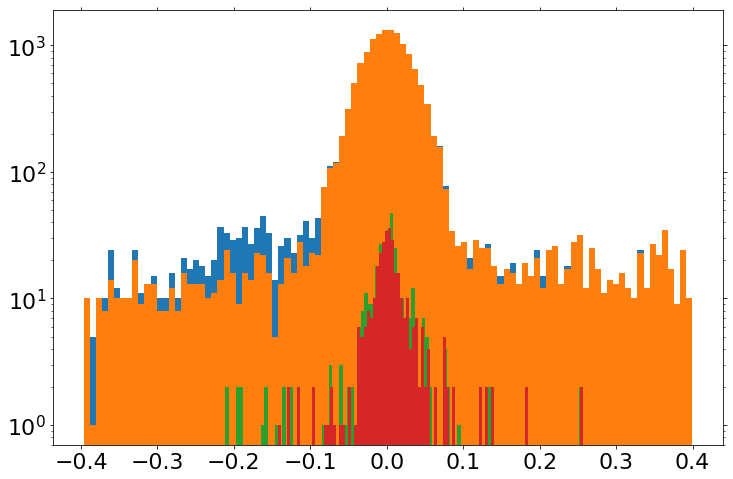

In [72]:
max_t = 0.4

plt.hist(np.concatenate(track_delta_t30)[np.abs(np.concatenate(track_delta_t30)) < max_t], bins = 100)
plt.hist(np.concatenate(link_track_delta_t30)[np.abs(np.concatenate(link_track_delta_t30)) < max_t], bins = 100)
plt.hist(np.concatenate(vtx_delta_t30)  [np.abs(np.concatenate(vtx_delta_t30)) < max_t]  , bins = 100)
plt.hist(np.concatenate(link_vtx_delta_t30)  [np.abs(np.concatenate(link_vtx_delta_t30)) < max_t]  , bins = 100)

plt.yscale('log')

In [40]:
bootstrapped_vtx_res = []
bootstrapped_vtx_res_std = []
for i in range(len(events_in_PU_bins)):
    bin_vtx_res = []
    for _ in range(1000):
        idx = np.random.randint(0, len(vtx_delta_t30[i]), len(vtx_delta_t30[i]))
        bin_vtx_res.append(np.sqrt(np.mean(np.array(vtx_delta_t30[i])[idx]**2)))
    bootstrapped_vtx_res.append(np.mean(bin_vtx_res))
    bootstrapped_vtx_res_std.append(np.std(bin_vtx_res))

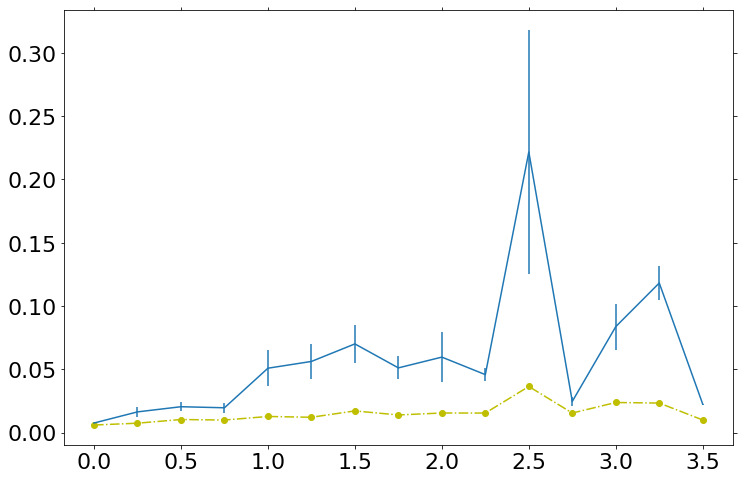

In [41]:
plt.errorbar(truth_bin_edges, bootstrapped_vtx_res, bootstrapped_vtx_res_std)
plt.plot(truth_bin_edges, np.array(track_vtx_t30_res), 'yo-.', label='Vtx resolution from tracks')


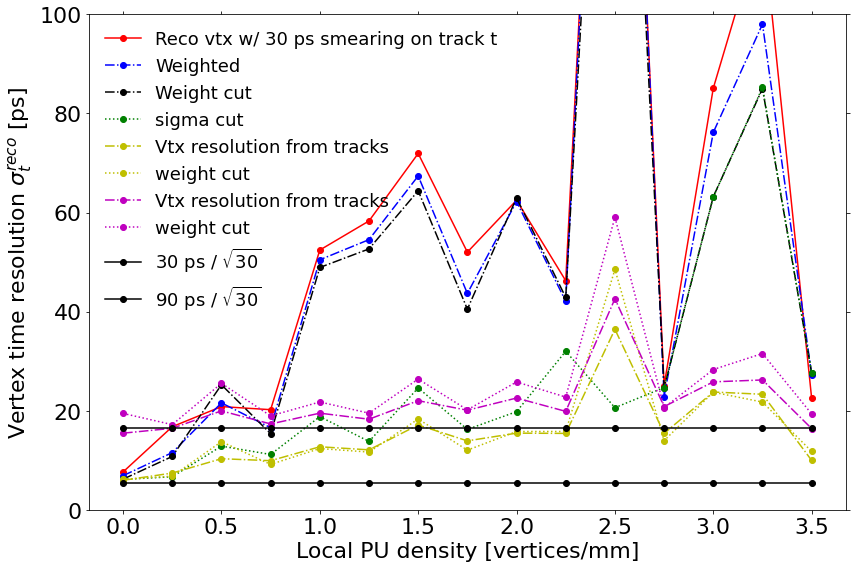

In [31]:
plt.plot(truth_bin_edges, 1e3*np.array(vtx_t30_res), 'ro-', label='Reco vtx w/ 30 ps smearing on track t')
plt.plot(truth_bin_edges, 1e3*np.array(vtx_weighted_t30_res), 'bo-.', label='Weighted')
plt.plot(truth_bin_edges, 1e3*np.array(vtx_weight_cut_t30_res), 'ko-.', label='Weight cut')
plt.plot(truth_bin_edges, 1e3*np.array(vtx_sigma_cut_weighted_t30_res), 'go:', label='sigma cut')


plt.plot(truth_bin_edges, 1e3*np.array(track_vtx_t30_res), 'yo-.', label='Vtx resolution from tracks')
plt.plot(truth_bin_edges, 1e3*np.array(track_vtx_t30_res_weight_cut), 'yo:', label='weight cut')

plt.plot(truth_bin_edges, 1e3*np.array(track_vtx_t90_res), 'mo-.', label='Vtx resolution from tracks')
plt.plot(truth_bin_edges, 1e3*np.array(track_vtx_t90_res_weight_cut), 'mo:', label='weight cut')

plt.plot(truth_bin_edges, 30/np.sqrt(30*np.ones(len(truth_bin_edges))), 'ko-', label='30 ps / $\\sqrt{30}$')
plt.plot(truth_bin_edges, 90/np.sqrt(30*np.ones(len(truth_bin_edges))), 'ko-', label='90 ps / $\\sqrt{30}$')

plt.ylim(0, 100)
plt.legend(frameon=False)
plt.xlabel('Local PU density [vertices/mm]')
plt.ylabel('Vertex time resolution $\\sigma^{reco}_t$ [ps]')
plt.tight_layout()

In [23]:
sigma_cut = 2

closest_truth_delta_t = []
closest_truth_delta_t_rms = []

closest_truth_vtx_t_res = []
closest_truth_vtx_weighted_t_res = []
closest_truth_vtx_weight_cut_t_res = []

closest_truth_vtx_t30_res = []
closest_truth_vtx_weighted_t30_res = []
closest_truth_vtx_weight_cut_t30_res = []

closest_truth_delta_t30 = []
closest_truth_delta_t30_rms = []
closest_truth_vtx_t30_res = []

closest_truth_vtx_t30_res_sigma_cut = []

events_in_PU_bins = []
for bin in truth_bin_edges:
    events_in_PU_bins.append(np.argwhere(np.isclose(truth_localPU, bin)))

avg_n_tracks = []
avg_n_tracks30 = []
avg_n_tracks30_sigma_cut = []

for event_idxs in events_in_PU_bins:
    bin_closest_truth_delta_t = np.array([])
    bin_closest_truth_delta_t_rms = []
    
    bin_closest_truth_delta_t30 = np.array([])
    bin_closest_truth_delta_t30_rms = []
    
    bin_closest_truth_vtx_delta_t = []
    bin_closest_truth_vtx_delta_t30 = []
    bin_closest_truth_vtx_weighted_delta_t = []
    bin_closest_truth_vtx_weighted_delta_t30 = []
    
    bin_closest_truth_vtx_weight_cut_delta_t = []
    bin_closest_truth_vtx_weight_cut_delta_t30 = []
    
    reco_n_tracks_events = []
    reco_n_tracks_events30 = []
    
    for idx in event_idxs:
        idx = idx[0]
        # reco_track_weights = reco_vertex_track_weights[idx][0]
        
        reco_vtx_z = reco_vertex_z[idx][0]
        truth_t = truth_vertex_t[idx][np.argmin(np.abs(truth_vertex_z[idx] - reco_vtx_z))]
        
        #Use reco HS - ie. largest sumpT2 vtx
        reco_track_t = track_t[idx][reco_vertex_track_idxs[idx][0]]
        reco_track_t_clean_idx = np.logical_and(reco_track_t != -1e3, reco_track_t != -1e6)
        reco_track_t = reco_track_t[np.logical_and(reco_track_t != -1e3, reco_track_t != -1e6)]
        
        reco_track_t30 = track_t30[idx][reco_vertex_track_idxs[idx][0]]
        reco_track_t30_clean_idx = np.logical_and(reco_track_t30 != -1e3, reco_track_t30 != -1e6)
        reco_track_t30 = reco_track_t30[reco_track_t30_clean_idx]
        
        diff_t = reco_track_t - truth_t
        diff_t30 = reco_track_t30 - truth_t
        
        reco_n_tracks_events.append(len(diff_t))
        reco_n_tracks_events30.append(len(diff_t30))
        
        bin_closest_truth_delta_t = np.concatenate((bin_closest_truth_delta_t, diff_t))
        bin_closest_truth_delta_t30 = np.concatenate((bin_closest_truth_delta_t30, diff_t30))
        
        bin_closest_truth_delta_t_rms.append(np.sqrt(np.mean(diff_t**2)))
        bin_closest_truth_delta_t30_rms.append(np.sqrt(np.mean(diff_t30**2)))
        
        
        reco_vtx_t = np.mean(reco_track_t)
        reco_vtx_t30 = np.mean(reco_track_t30)
        
        # reco_vtx_weighted_t = np.average(reco_track_t, weights=reco_track_weights[reco_track_t_clean_idx])
        # reco_vtx_weighted_t30 = np.mean(reco_track_t30, weights=reco_track_weights[reco_track_t30_clean_idx])
        
        bin_closest_truth_vtx_delta_t.append(reco_vtx_t - truth_t)
        bin_closest_truth_vtx_delta_t30.append(reco_vtx_t30 - truth_t)
        # bin_closest_truth_vtx_weighted_delta_t.append(reco_vtx_weighted_t - truth_t)
        # bin_closest_truth_vtx_weighted_delta_t30.append(reco_vtx_weighted_t30 - truth_t)
        
    
    avg_n_tracks.append(np.mean(reco_n_tracks_events))
    avg_n_tracks30.append(np.mean(reco_n_tracks_events30))
    
    closest_truth_delta_t.append(bin_closest_truth_delta_t)
    closest_truth_delta_t30.append(bin_closest_truth_delta_t30)
    
    closest_truth_delta_t_rms.append(bin_closest_truth_delta_t_rms)
    closest_truth_delta_t30_rms.append(bin_closest_truth_delta_t30_rms)
    
    closest_truth_vtx_t_res.append(np.mean(bin_closest_truth_delta_t_rms / np.sqrt(np.array(reco_n_tracks_events))))
    closest_truth_vtx_t30_res.append(np.mean(bin_closest_truth_delta_t30_rms / np.sqrt((np.array(reco_n_tracks_events30)))))
    
    bin_sigma30 = np.std(bin_closest_truth_delta_t30)
    bin_closest_truth_t30_diff_std_of_mean_sigma_cut = []
    reco_n_tracks_events_cut = []
    for idx in event_idxs:
        diff_t30_sigma_cut = diff_t30[np.abs(diff_t30 - np.mean(diff_t30)) < sigma_cut*bin_sigma30]
        reco_n_tracks_events_cut.append(len(diff_t30_sigma_cut))
        bin_closest_truth_t30_diff_std_of_mean_sigma_cut.append(np.std(diff_t30_sigma_cut)/np.sqrt(len(diff_t30_sigma_cut)))
    closest_truth_vtx_t30_res_sigma_cut.append(np.mean(bin_closest_truth_t30_diff_std_of_mean_sigma_cut))
    avg_n_tracks30_sigma_cut.append(np.mean(reco_n_tracks_events_cut))

Text(0.5, 0, 'Reco vtx track t - truth track t [ps]')

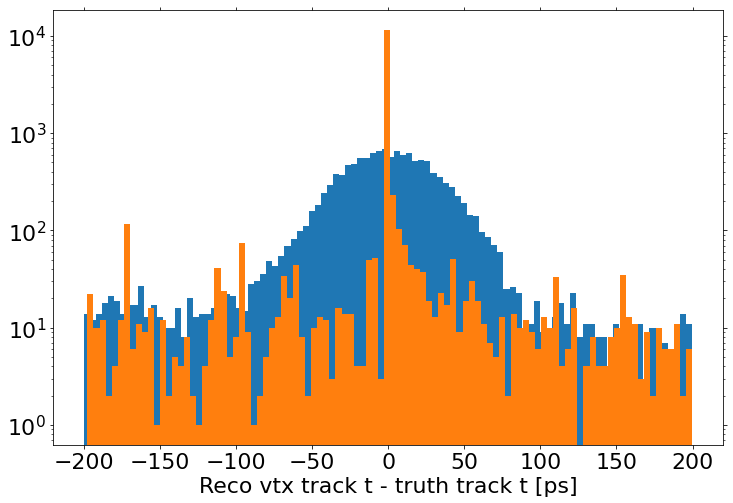

In [24]:
_ = plt.hist(1e3*np.concatenate(closest_truth_delta_t30)[np.abs(np.concatenate(closest_truth_delta_t30))<0.2], bins=100, label='No smearing')
_ = plt.hist(1e3*np.concatenate(closest_truth_delta_t)[np.abs(np.concatenate(closest_truth_delta_t))<0.2],     bins=100, label='30 ps smearing')
plt.yscale('log')
plt.xlabel('Reco vtx track t - truth track t [ps]')

Text(0, 0.5, 'Vertex time resolution $\\sigma^{reco}_t$ [ps]')

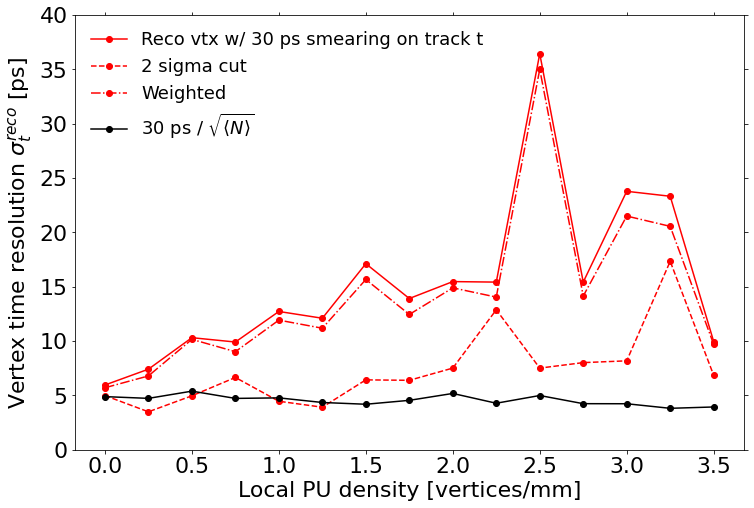

In [67]:
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_vtx_t30_res), 'ro-', label='Reco vtx w/ 30 ps smearing on track t')
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_vtx_t30_res_sigma_cut), 'ro--', label='{} sigma cut'.format(sigma_cut))
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_vtx_t30_weighted_res), 'ro-.', label='Weighted')
plt.plot(truth_bin_edges, 30/np.sqrt(avg_n_tracks), 'ko-', label='30 ps / $\\sqrt{\\langle N\\rangle}$')

plt.ylim(0, 40)
plt.legend(frameon=False)
plt.xlabel('Local PU density [vertices/mm]')
plt.ylabel('Vertex time resolution $\\sigma^{reco}_t$ [ps]')

In [ ]:
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_t30_diff_avg_std_of_mean), 'ro-', label='Reco vtx w/ 30 ps smearing on track t')
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_t30_diff_std_of_mean_sigma_cut), 'ro--', label='{} sigma cut'.format(sigma_cut))
plt.plot(truth_bin_edges, 30/np.sqrt(avg_n_tracks), 'ko-', label='30 ps / $\\sqrt{\\langle N\\rangle}$')

plt.ylim(0, 30)
plt.legend(frameon=False)
plt.xlabel('Local PU density [vertices/mm]')
plt.ylabel('Vertex time resolution $\\sigma^{reco}_t$ [ps]')